In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.util as model_util
import model.mechint_net as mechint_net
import feature.experimental_dataset as experimental_dataset
import feature.util as feature_util
import train.train_model as train_model
import analysis.motif_compare as motif_compare
import analysis.motif_util as motif_util
import plot.plot_motifs as plot_motifs
import plot.plot as plot
import extract.dinuc_shuffle as dinuc_shuffle
import grelu.resources
import pysam
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import pandas as pd
import scipy.stats
import tqdm.notebook

In [2]:
# Plotting defaults
font_files = font_manager.findSystemFonts(fontpaths="/home/tsenga5/lib/fonts")
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.size": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
base_path = "/projects/site/gred/resbioai/tsenga5/mechint_regnet/"

In [5]:
model_path = os.path.join(base_path, "models/trained_models/experimental/dnase_hepg2/mechint_net/3/last_ckpt.pth")
peaks_bed_path = os.path.join(base_path, "data/encode/dnase/ENCSR149XIL_HepG2/ENCFF897NME_peaks.bed.gz")

In [6]:
known_motifs_path = "/home/tsenga5/mechint_regnet/data/databases/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme_sanitname.txt"

In [7]:
out_path = "/home/tsenga5/mechint_regnet/results/interpretable_seq_gen_synthesis"
os.makedirs(out_path, exist_ok=True)

### Import model and create data loader

In [8]:
model = model_util.load_model(
    mechint_net.MechIntRegNet, model_path
).to(DEVICE)

In [9]:
data_loader = experimental_dataset.dataset_ex.run(
    "create_data_loader", config_updates={
        "peaks_bed_path": peaks_bed_path,
        "input_length": 200,
        "batch_size": 512,
        "chrom_set": ["chr1"],
        "negative_ratio": 0,  # Positives only
        "return_coords": True
    }
).result

data_loader.dataset.on_epoch_start()

WARNING - root - Added new config entry: "chrom_set"
WARNING - root - Added new config entry: "peaks_bed_path"
WARNING - root - Added new config entry: "return_coords"
WARNING - exp_dataset - No observers have been added to this run
INFO - exp_dataset - Running command 'create_data_loader'
INFO - exp_dataset - Started
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - exp_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x14c75a78e6c0>
INFO - exp_dataset - Completed after 0:00:00


### Construct motifs

In [10]:
def model_to_pfms(model, data_loader, max_thresh_frac=0.5):
    """
    Given a model and a data loader, runs through the input sequences
    in the data loader and collects convolutional activations from the
    entire epoch.
    Returns a F x W x 4 array of PFMs for the filters. If a filter is
    never activated, its PFM will be all 0.
    """
    _, _, _, _, model_outputs_other, input_data = \
        train_model.run_epoch(data_loader, "eval", model, epoch_num=0, return_extras=True)
    conv_acts = model_outputs_other["conv_acts"]  # Shape: N x L' x F
    input_seqs = input_data[0]  # Shape: N x L x 4
    num_filters = conv_acts.shape[2]
    filter_width = input_seqs.shape[1] - conv_acts.shape[1] + 1

    # Compute minimum activations needed
    act_threshes = np.max(conv_acts, axis=(0, 1)) * max_thresh_frac

    # Construct PFMs
    pfms = np.zeros((num_filters, filter_width, 4))
    for i in range(num_filters):
        if act_threshes[i] == 0:
            continue
        ex_inds, start_inds = np.where(conv_acts[:, :, i] > act_threshes[i])
        if not ex_inds.size:
            # Nothing passed the threshold
            continue
        # Trick to get all matching subsequences, where we flatten the set of all
        # indices we want and then reshape
        seqs = input_seqs[
            np.repeat(ex_inds, filter_width),
            (np.arange(filter_width)[None] + start_inds[:, None]).reshape(-1)
        ].reshape(len(ex_inds), filter_width, -1)
        pfms[i] = np.mean(seqs, axis=0)

    return pfms

In [11]:
pfms = model_to_pfms(model, data_loader)
pfms_used = [np.sum(pfm) > 0 for pfm in pfms]

	Loss: 0.8984: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.43it/s]


### Assign identities to motifs

In [12]:
def extract_tomtom_matches(num_motifs, tomtom_matches):
    """
    Takes a dictionary of TOMTOM matches (keys are indices) and a maximum
    number of motifs, and returns a list of length `num_motifs`, where each
    entry is a list of tuples of the matches (each tuple is the matched motif
    key, whether or not the match is reverse-complemented, and the -log(q-value).
    """
    result = [None] * num_motifs
    for i in range(num_motifs):
        try:
            subtable = tomtom_matches[i]
            subtable = subtable.sort_values("q-value")
            subtable["RC"] = subtable["Orientation"] == "-"
            subtable["Score"] = -np.log10(subtable["q-value"])
            result[i] = [tuple(row) for row in subtable[["Target_ID", "RC", "Score"]].values]
        except KeyError:
            result[i] = []
    return result

In [13]:
# Run TOMTOM to match each motif to a known motif/TF
known_motifs = motif_util.import_meme_motifs(known_motifs_path)

match_subtables = motif_compare.run_tomtom(
    {i : pfm for i, pfm in enumerate(pfms) if pfms_used[i]}, known_motifs
)
motif_sims = extract_tomtom_matches(len(pfms), match_subtables)
motif_top_matches = [motif_sims[i][0][0] if pfms_used[i] and motif_sims[i] else None for i in range(len(pfms))]

/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/gr

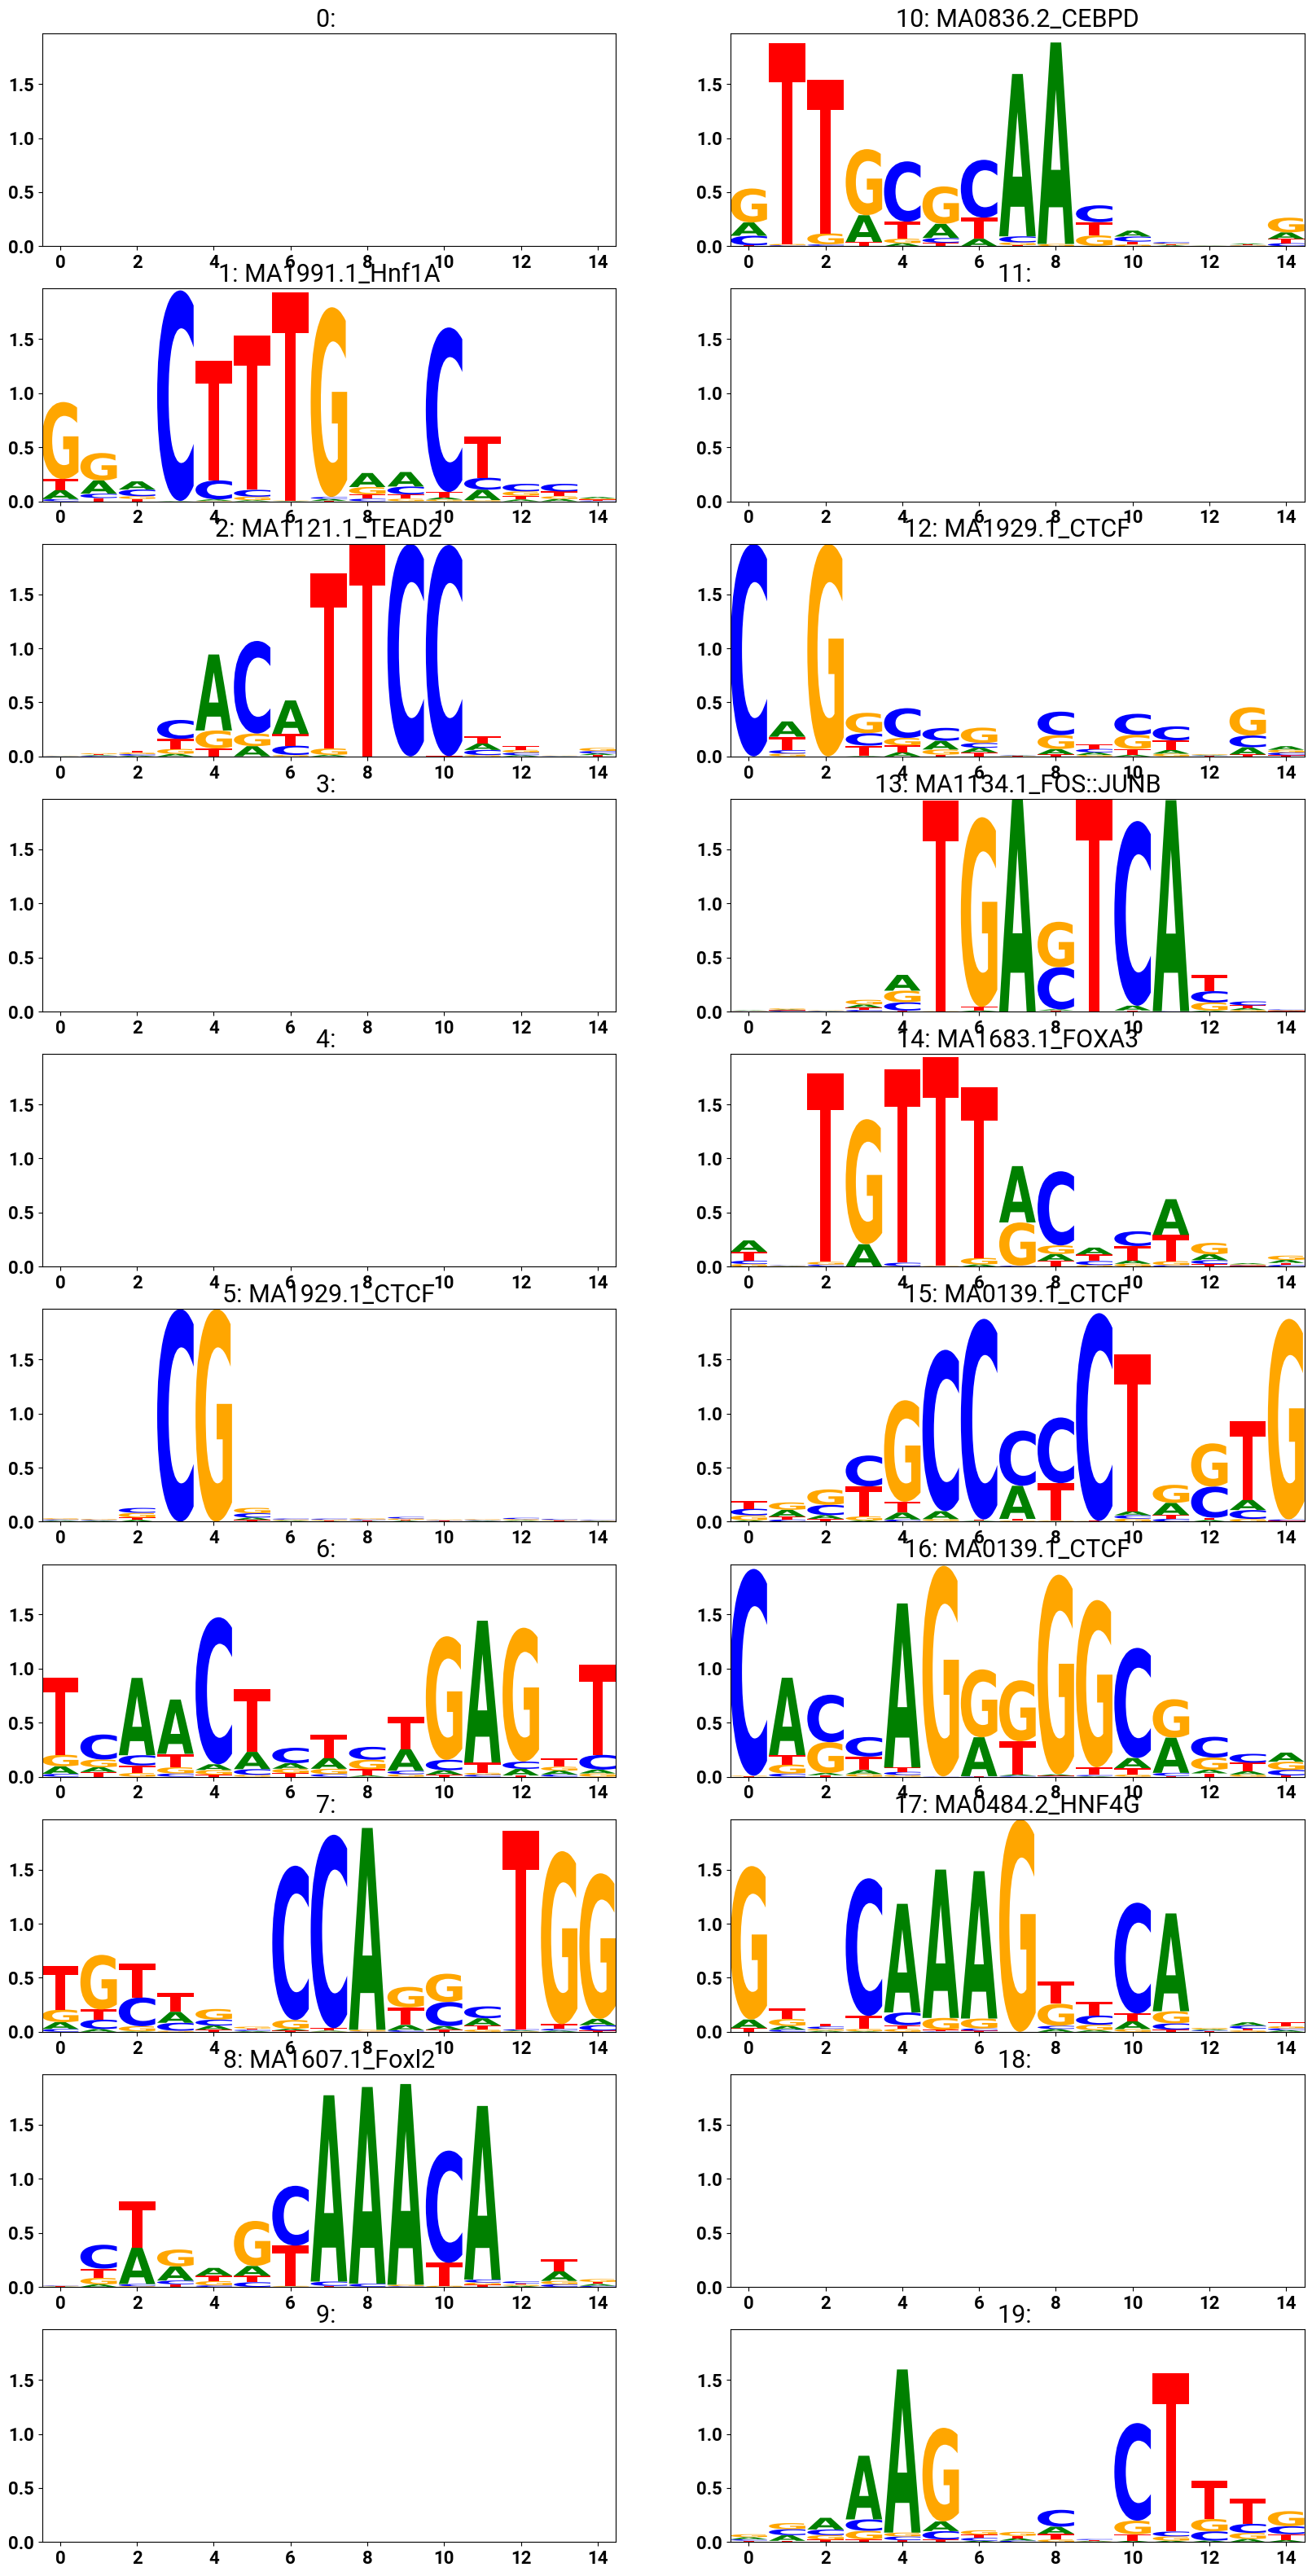

In [14]:
fig = plot_motifs.plot_motif_grid(
    [pfm * motif_util.pfm_info_content(pfm)[:, None] for pfm in pfms],
    titles=["%d: %s" % (i, match if match else "") for i, match in enumerate(motif_top_matches)]
)

### Extract motif instances and global rules

In [15]:
# Run through an epoch and extract key outputs
_, _, model_outputs, _, model_outputs_other, input_data = \
    train_model.run_epoch(data_loader, "eval", model, epoch_num=0, return_extras=True)

true_labels, pred_probs = np.squeeze(input_data[1], axis=1), np.squeeze(model_outputs, axis=1)
input_coords = input_data[2]
input_one_hots = input_data[0]
conv_acts = model_outputs_other["conv_acts"]  # Shape: N x L' x F
att_vals = model_outputs_other["att_vals"]  # Shape: N x AL x NH x L'

/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
	Loss: 0.8391: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:03<00:00, 12.64it/s]


In [16]:
# For each positive example, find the maximum attention values and map them to motifs (and their positions)
pos_att_vals = att_vals[true_labels == 1]
pos_conv_acts = conv_acts[true_labels == 1]

motif_hits = []

# For each filter, get a distribution activations
filter_mean_acts = np.empty(pos_conv_acts.shape[2])
for filter_i in range(pos_conv_acts.shape[2]):
    acts = pos_conv_acts[:, :, filter_i]
    acts = acts[acts > 0]  # Only positive activations
    filter_mean_acts[filter_i] = np.mean(acts)

# For each example, get the positions which had a high attention score
for ex_i in range(len(pos_att_vals)):
    att_scores = pos_att_vals[ex_i]  # Shape: AL x AH x L'

    # Get positions with high attention score
    mask = np.any(att_scores > 0.9, axis=(0, 1))  # Collapse over attention layers and heads
    inds = np.where(mask)[0]

    ex_motif_hits = []

    # For each position, figure out which motif is firing
    for hit_pos in inds:
        acts = pos_conv_acts[ex_i, hit_pos]
        filter_hits = acts > filter_mean_acts
        if not np.any(filter_hits):
            # Got a high attention score, but no motif hit here
            continue
        filter_inds = np.where(filter_hits)[0]
        ex_motif_hits.append((hit_pos, [(i, motif_top_matches[i]) for i in filter_inds]))
    motif_hits.append(ex_motif_hits)        

/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [17]:
# Filter PFMs for high-quality motifs
min_average_ic = 0.8
min_length = 5
    
# Trim by IC
trimmed_pfms = {i : motif_util.trim_motif_by_low_ic(pfm, motif_util.pfm_info_content(pfm)) for i, pfm in enumerate(pfms)}

# Require trimmed length to be at least minimum
trimmed_pfms = {i : pfm for i, pfm in trimmed_pfms.items() if len(pfm) >= min_length}

# Require total IC to be at least minimum
trimmed_pfms = {i : pfm for i, pfm in trimmed_pfms.items() if np.mean(motif_util.pfm_info_content(pfm)) >= min_average_ic}

passed_pfms = set(trimmed_pfms.keys())

print("Total used PFMs: %d" % sum(np.sum(pfm) > 0 for pfm in pfms))
print("Total passed PFMs: %d" % len(passed_pfms))
print("PFM lengths", {i : len(pfm) for i, pfm in trimmed_pfms.items()})

Total used PFMs: 14
Total passed PFMs: 10
PFM lengths {1: 12, 2: 8, 6: 15, 7: 15, 8: 13, 13: 9, 14: 13, 15: 13, 16: 15, 17: 12}


In [18]:
# Save passed PFMs and keys
save_pfms = {}
for i in passed_pfms:
    match = motif_top_matches[i]
    if not match:
        continue
    key = "%d-%s" % (i, match)
    save_pfms[key] = pfms[i]
np.savez(os.path.join(out_path, "pfms.npz"), **save_pfms)

In [19]:
# Isolate sequences with only TOMTOM-matched and only passed motifs
matched_only_inds = np.array([
    i for i, row in enumerate(motif_hits) if
    row and \
        all(any(match is not None for match in [matches[1] for matches in hit[1]]) for hit in row) and \
        all(any(ind in passed_pfms for ind in [matches[0] for matches in hit[1]]) for hit in row)
])
    
motif_hits_matched_only = [motif_hits[i] for i in matched_only_inds]
input_one_hots_matched_only = input_one_hots[matched_only_inds]
input_coords_matched_only = input_coords[matched_only_inds]

In [20]:
# Some statistics
print("Number of sequences: %d" % len(motif_hits))
print("Number of sequences with found hits: %d" % sum(len(row) > 0 for row in motif_hits))
print("Number of sequences with found hits with only matched/passed motifs: %d" % len(motif_hits_matched_only))

Number of sequences: 23916
Number of sequences with found hits: 22907
Number of sequences with found hits with only matched/passed motifs: 4056


### Construct new sequences

In [21]:
# For sequences with only matched motifs, summarize the most common patterns
pattern_inds = {}
for i, row in enumerate(motif_hits_matched_only):
    hit_matches = [hit[1] for hit in row]
    if not all(len(m) == 1 for m in hit_matches):
        # Require each hit to be mapped to only one motif, for simplicity
        continue
    pattern = tuple([m[0] for m in hit_matches])
    try:
        pattern_inds[pattern].append(i)
    except KeyError:
        pattern_inds[pattern] = [i]

for pattern_key in pattern_inds:
    pattern_inds[pattern_key] = np.array(pattern_inds[pattern_key])

for pattern_key in sorted(pattern_inds.keys(), key=(lambda k: -len(pattern_inds[k])))[:20]:
    print(pattern_key, len(pattern_inds[pattern_key]))

((2, 'MA1121.1_TEAD2'),) 613
((8, 'MA1607.1_Foxl2'),) 559
((16, 'MA0139.1_CTCF'),) 448
((14, 'MA1683.1_FOXA3'),) 218
((13, 'MA1134.1_FOS::JUNB'),) 176
((16, 'MA0139.1_CTCF'), (2, 'MA1121.1_TEAD2')) 115
((2, 'MA1121.1_TEAD2'), (16, 'MA0139.1_CTCF')) 113
((8, 'MA1607.1_Foxl2'), (2, 'MA1121.1_TEAD2')) 104
((2, 'MA1121.1_TEAD2'), (8, 'MA1607.1_Foxl2')) 83
((13, 'MA1134.1_FOS::JUNB'), (2, 'MA1121.1_TEAD2')) 76
((2, 'MA1121.1_TEAD2'), (13, 'MA1134.1_FOS::JUNB')) 60
((16, 'MA0139.1_CTCF'), (8, 'MA1607.1_Foxl2')) 55
((8, 'MA1607.1_Foxl2'), (13, 'MA1134.1_FOS::JUNB')) 52
((13, 'MA1134.1_FOS::JUNB'), (8, 'MA1607.1_Foxl2')) 46
((16, 'MA0139.1_CTCF'), (14, 'MA1683.1_FOXA3')) 38
((8, 'MA1607.1_Foxl2'), (16, 'MA0139.1_CTCF')) 37
((13, 'MA1134.1_FOS::JUNB'), (14, 'MA1683.1_FOXA3')) 29
((14, 'MA1683.1_FOXA3'), (13, 'MA1134.1_FOS::JUNB')) 22
((14, 'MA1683.1_FOXA3'), (16, 'MA0139.1_CTCF')) 22
((13, 'MA1134.1_FOS::JUNB'), (8, 'MA1607.1_Foxl2'), (2, 'MA1121.1_TEAD2')) 9


In [22]:
def sample_pfm(motif):
    """
    Samples a random one-hot sequence from a motif probability matrix.
    Arguments:
        `motif`: an L x D array of probabilities
    Returns a one-hot L x D array.
    """
    # Renormalize to ensure it sums to 1
    motif = motif / np.sum(motif, axis=1, keepdims=True)
    prob_cumsums = np.cumsum(motif, axis=1)
    return np.eye(4)[np.array([
        np.searchsorted(probs, np.random.random()) for probs in prob_cumsums
    ])]

In [23]:
def dinuc_shuffle_one_hot_window(one_hot, start, end):
    """
    Dinucleotide-shuffles a window of a one-hot-encoded sequence, leaving the
    rest intact. The interval is half-open (Pythonic).
    Arguments:
        `one_hot`: a L x 4 array which is a one-hot-encoded sequence
        `start`: start index to shuffle (inclusive)
        `end`: end index to shuffle (exclusive)
    Returns a partially shuffled L x 4 array.
    """
    assert start >= 0 and start < len(one_hot)
    assert end >= 0 and end <= len(one_hot)
    assert start < end
    result = one_hot.copy()
    result[start:end] = dinuc_shuffle.dinuc_shuffle(result[start:end], 1)[0]
    return result

In [24]:
# For the top patterns, construct new sequences with those patterns
min_pattern_count = 5
num_seqs_per_pattern_1, num_seqs_per_pattern_2 = 32, 128
center_shuffle_len = 200
cons_one_hots, cons_configs = [], []
orig_one_hots, shuf_one_hots = [], []
orig_coords = []

# Take most common patterns with 1 or 2 motifs
sorted_pattern_keys = sorted(pattern_inds.keys(), key=(lambda k: -len(pattern_inds[k])))
top_pattern_keys = [key for key in sorted_pattern_keys if len(key) < 3 and len(pattern_inds[key]) >= min_pattern_count]

# Show the top pattern keys and their counts
for key in top_pattern_keys:
    print("%d\t%s" % (len(pattern_inds[key]), key))

for pattern_key in top_pattern_keys:
    # Take sample of sequences for the pattern
    pattern_one_hots = input_one_hots_matched_only[pattern_inds[pattern_key]]
    pattern_coords = input_coords_matched_only[pattern_inds[pattern_key]]
    
    # Always take `num_seqs_per_pattern` sequences; they will be shuffled anyways
    num_seqs_per_pattern = num_seqs_per_pattern_1 if len(pattern_key) == 1 else num_seqs_per_pattern_2
    sample_inds = np.random.choice(len(pattern_one_hots), size=num_seqs_per_pattern, replace=True)
    sample_one_hots = pattern_one_hots[sample_inds]
    sample_coords = pattern_coords[sample_inds]
    orig_one_hots.append(sample_one_hots.copy())

    # For each sequence, dinucleotide shuffle to create new background
    input_len = sample_one_hots.shape[1]
    shuffle_start = (input_len // 2) - (center_shuffle_len // 2)
    shuffle_end = shuffle_start + center_shuffle_len
    shuffled_one_hots = np.stack([
        dinuc_shuffle_one_hot_window(one_hot, shuffle_start, shuffle_end) for one_hot in sample_one_hots
    ])
    shuf_one_hots.append(shuffled_one_hots.copy())

    # Sample from empirical spacings and PFMs
    inds = pattern_inds[pattern_key]
    rows = [motif_hits_matched_only[i] for i in inds]
    for sample_i, hit_i in enumerate(np.random.choice(len(rows), size=num_seqs_per_pattern, replace=True)):
        row = rows[hit_i]
        config = []
        for pos_ind, pattern in row:
            # `pattern` is guaranteed at this point to be a single pair in a list
            filter_ind = pattern[0][0] 

            # Sample sequence from the PFM at the filter index
            motif_one_hot = sample_pfm(pfms[filter_ind])

            # Place it in the corresponding shuffled sequence at `pos_ind`
            shuffled_one_hots[sample_i][pos_ind : pos_ind + len(motif_one_hot)] = motif_one_hot
            config.append((pos_ind, "%d-%s" % pattern[0]))

        cons_one_hots.append(shuffled_one_hots[sample_i].copy())
        cons_configs.append((tuple(sample_coords[sample_i]), config))
        orig_coords.append(tuple(sample_coords[sample_i]))

cons_one_hots = np.stack(cons_one_hots)
orig_one_hots = np.concatenate(orig_one_hots)
shuf_one_hots = np.concatenate(shuf_one_hots)

613	((2, 'MA1121.1_TEAD2'),)
559	((8, 'MA1607.1_Foxl2'),)
448	((16, 'MA0139.1_CTCF'),)
218	((14, 'MA1683.1_FOXA3'),)
176	((13, 'MA1134.1_FOS::JUNB'),)
115	((16, 'MA0139.1_CTCF'), (2, 'MA1121.1_TEAD2'))
113	((2, 'MA1121.1_TEAD2'), (16, 'MA0139.1_CTCF'))
104	((8, 'MA1607.1_Foxl2'), (2, 'MA1121.1_TEAD2'))
83	((2, 'MA1121.1_TEAD2'), (8, 'MA1607.1_Foxl2'))
76	((13, 'MA1134.1_FOS::JUNB'), (2, 'MA1121.1_TEAD2'))
60	((2, 'MA1121.1_TEAD2'), (13, 'MA1134.1_FOS::JUNB'))
55	((16, 'MA0139.1_CTCF'), (8, 'MA1607.1_Foxl2'))
52	((8, 'MA1607.1_Foxl2'), (13, 'MA1134.1_FOS::JUNB'))
46	((13, 'MA1134.1_FOS::JUNB'), (8, 'MA1607.1_Foxl2'))
38	((16, 'MA0139.1_CTCF'), (14, 'MA1683.1_FOXA3'))
37	((8, 'MA1607.1_Foxl2'), (16, 'MA0139.1_CTCF'))
29	((13, 'MA1134.1_FOS::JUNB'), (14, 'MA1683.1_FOXA3'))
22	((14, 'MA1683.1_FOXA3'), (13, 'MA1134.1_FOS::JUNB'))
22	((14, 'MA1683.1_FOXA3'), (16, 'MA0139.1_CTCF'))
8	((17, 'MA0484.2_HNF4G'),)
7	((8, 'MA1607.1_Foxl2'), (14, 'MA1683.1_FOXA3'))
7	((8, 'MA1607.1_Foxl2'), (8, 'MA1

### Test new sequences on ARGMINN

In [25]:
def get_mechint_predictions(model, one_hots):
    """
    Given a trained model and B x L x 4 NumPy array of one-hot sequences,
    runs predictions and returns the B-array of predicted probabilities.
    """
    return model(torch.tensor(one_hots).to(DEVICE).float()).squeeze().detach().cpu().numpy()

In [26]:
# Compute predictions
cons_mechint_preds = get_mechint_predictions(model, cons_one_hots)
cons_mechint_rc_preds = get_mechint_predictions(model, np.flip(cons_one_hots, axis=(1, 2)).copy())
orig_mechint_preds = get_mechint_predictions(model, orig_one_hots)
shuf_mechint_preds = get_mechint_predictions(model, shuf_one_hots)

In [27]:
def equal_aspect_scatter(data_x, data_y, ax, color):
    ax.scatter(data_x, data_y, color=color, alpha=0.3)
    lims = [
        np.min([data_x, data_y]),
        np.max([data_x, data_y])
    ]
    ax.plot(lims, lims, linestyle="--", color="black", alpha=0.5, zorder=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect("equal")

def plot_pred_distributions(cons_preds, cons_rc_preds, orig_preds, shuf_preds):
    fig = plt.figure(figsize=(20, 20))
    
    ax = fig.add_subplot(4, 2, (1, 2))
    ax.hist(cons_preds, bins=100, histtype="step", density=True, color="royalblue")
    ax.set_xlabel("Predicted accessibility of constructed sequences")

    ax = fig.add_subplot(4, 2, 3)
    equal_aspect_scatter(cons_preds, cons_rc_preds, ax, "royalblue")
    ax.set_xlabel("Constructed (forward)")
    ax.set_ylabel("Constructed (reverse)")

    ax = fig.add_subplot(4, 2, 4)
    bin_heights, bin_edges, _ = ax.hist(cons_preds - cons_rc_preds, bins=100, histtype="step", density=True, color="royalblue")
    pval = scipy.stats.wilcoxon(cons_preds, cons_rc_preds, alternative="two-sided")[1]
    ax.text(np.min(bin_edges), np.max(bin_heights), "2-sided p-value: %.5e" % pval)
    ax.axvline(0, linestyle="--", color="black", alpha=0.5)
    ax.set_xlabel("Predicted accessibility: constructed (forward) - constructed (reverse)")

    ax = fig.add_subplot(4, 2, 5)
    equal_aspect_scatter(cons_preds, orig_preds, ax, "firebrick")
    ax.set_xlabel("Constructed")
    ax.set_ylabel("Original")

    ax = fig.add_subplot(4, 2, 6)
    bin_heights, bin_edges, _ = ax.hist(cons_preds - orig_preds, bins=100, histtype="step", density=True, color="firebrick")
    pval = scipy.stats.wilcoxon(cons_preds, orig_preds, alternative="two-sided")[1]
    ax.text(np.min(bin_edges), np.max(bin_heights), "2-sided p-value: %.5e" % pval)
    ax.axvline(0, linestyle="--", color="black", alpha=0.5)
    ax.set_xlabel("Predicted accessibility: constructed - original")

    ax = fig.add_subplot(4, 2, 7)
    equal_aspect_scatter(cons_preds, shuf_preds, ax, "darkviolet")
    ax.set_xlabel("Constructed")
    ax.set_ylabel("Shuffled")

    ax = fig.add_subplot(4, 2, 8)
    bin_heights, bin_edges, _ = ax.hist(cons_preds - shuf_preds, bins=100, histtype="step", density=True, color="darkviolet")
    pval = scipy.stats.wilcoxon(cons_preds, shuf_preds, alternative="greater")[1]
    ax.text(np.min(bin_edges), np.max(bin_heights), "1-sided p-value: %.5e" % pval)
    ax.axvline(0, linestyle="--", color="black", alpha=0.5)
    ax.set_xlabel("Predicted accessibility: constructed - shuffled")

    fig.tight_layout()
    plt.show()

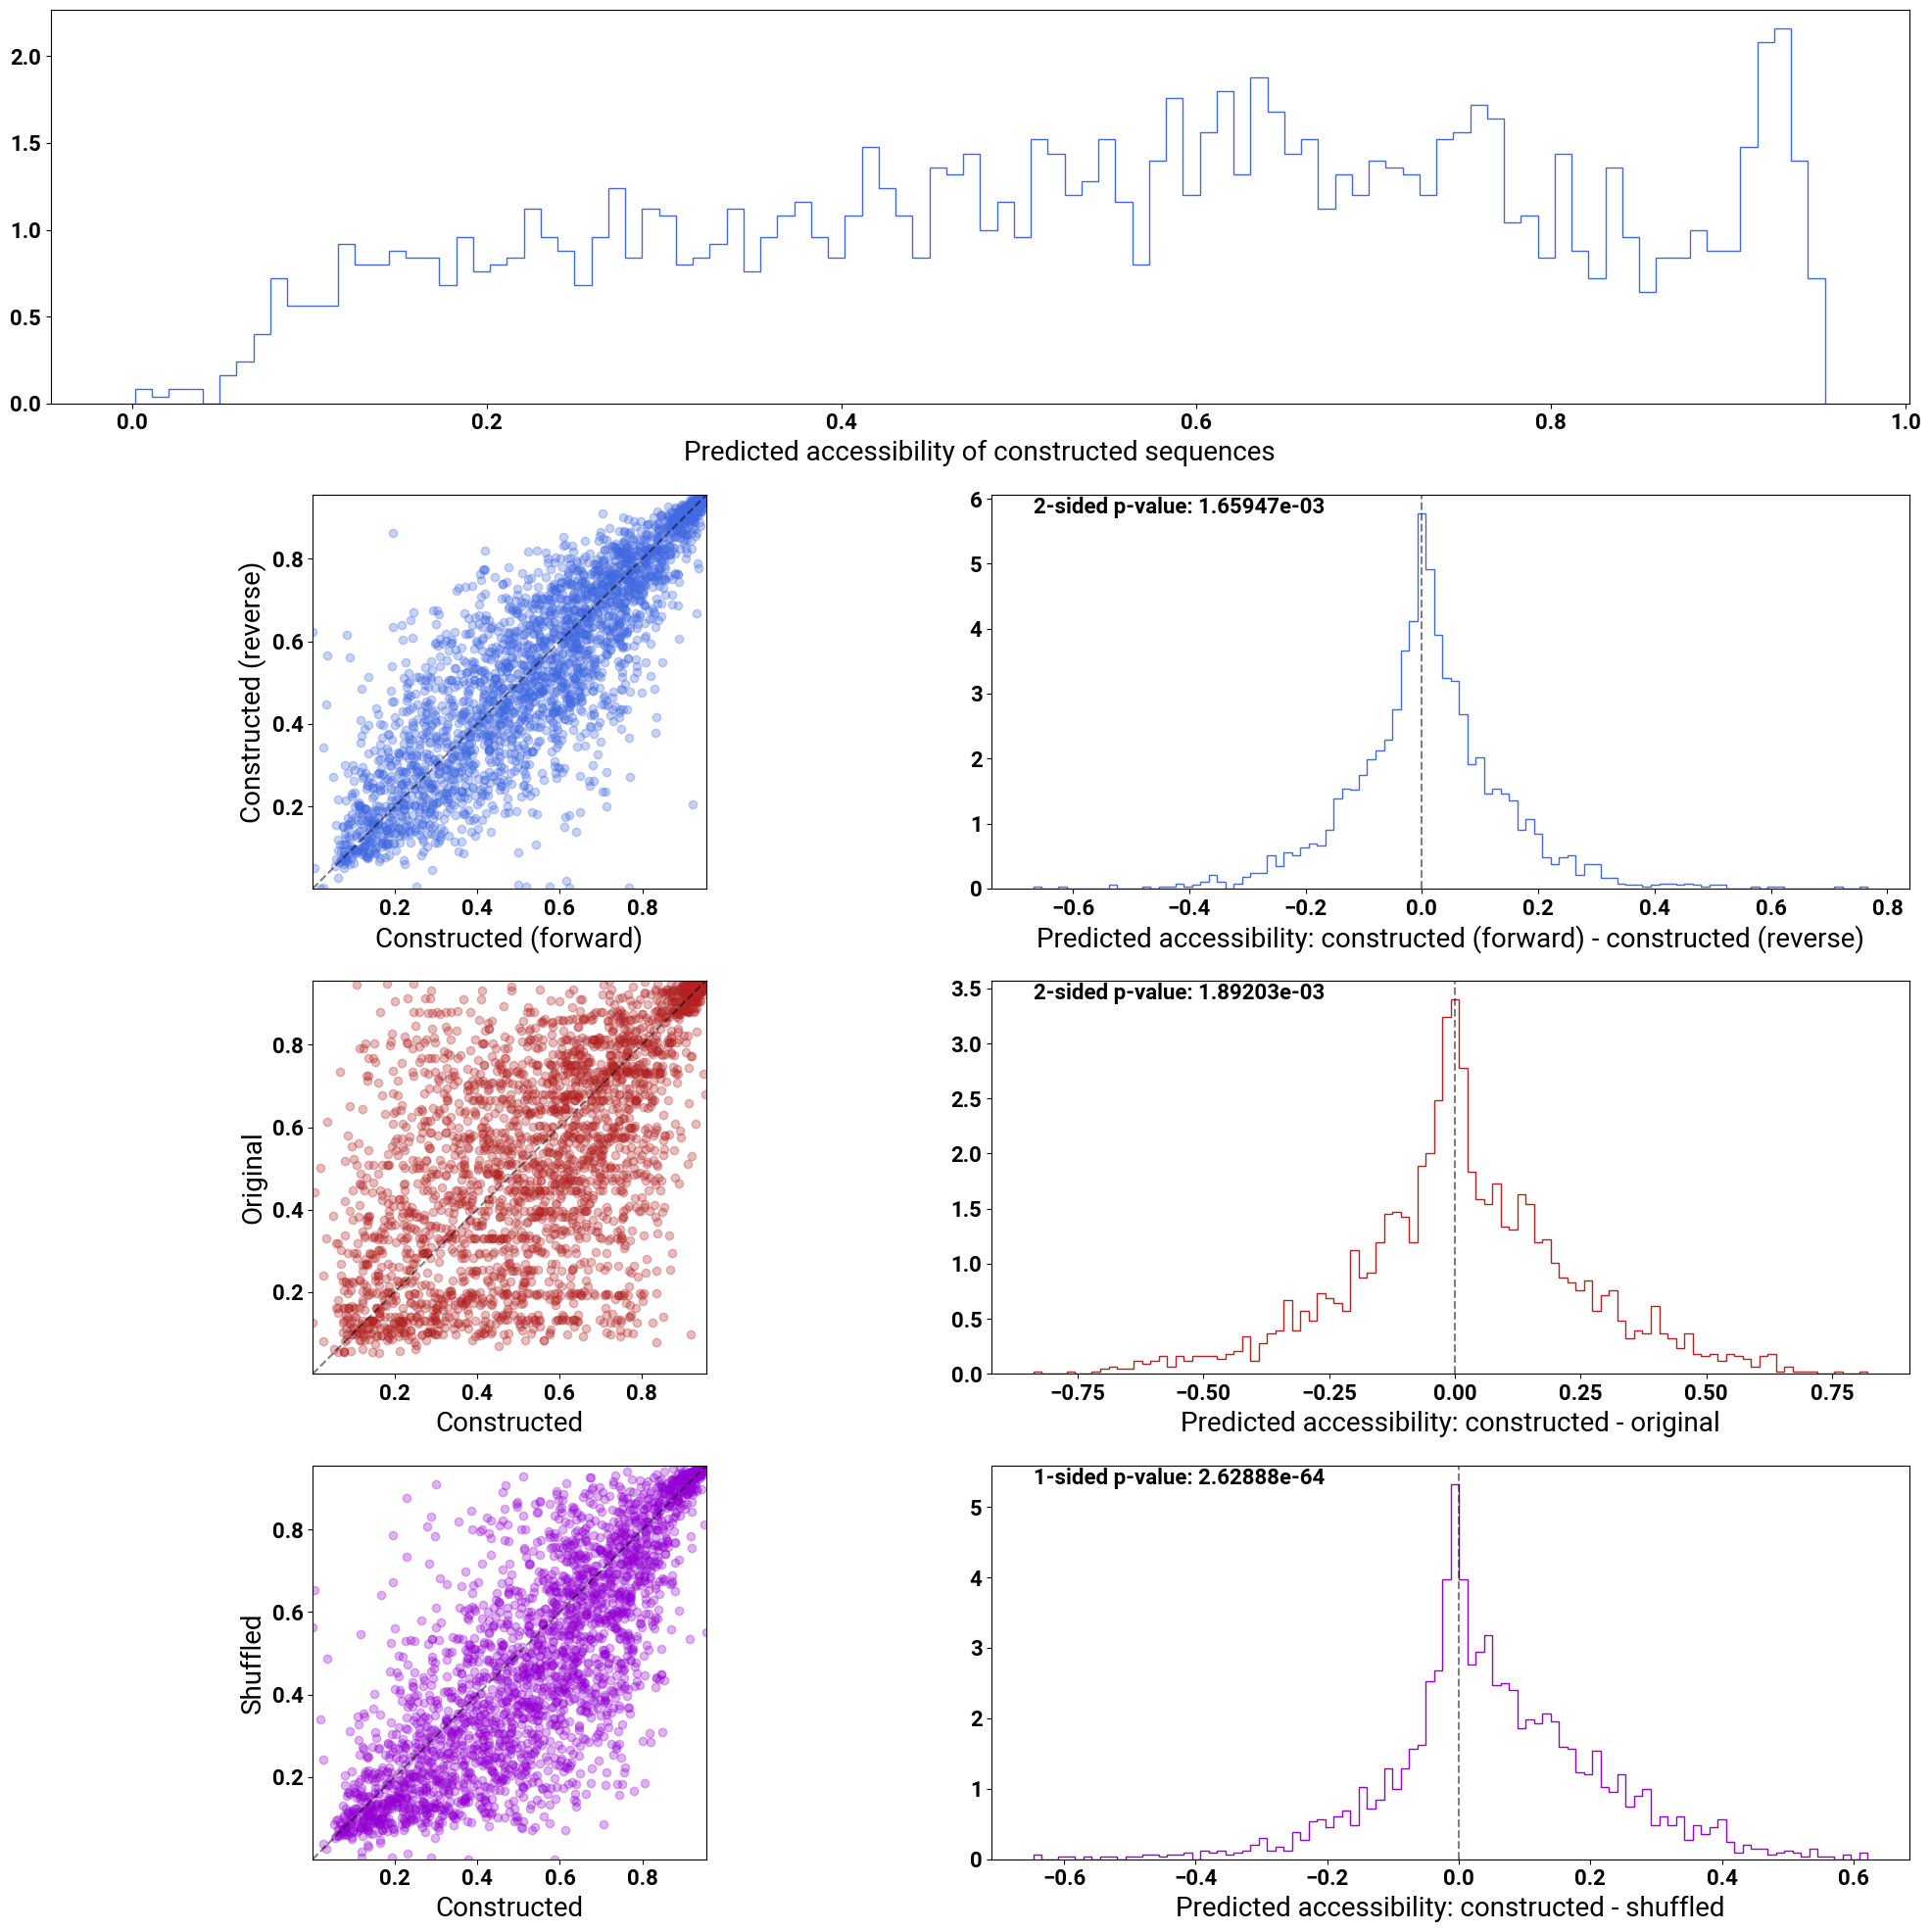

In [28]:
# Plot distribution of predictions
plot_pred_distributions(cons_mechint_preds, cons_mechint_rc_preds, orig_mechint_preds, shuf_mechint_preds)

### Test new sequences on Borzoi

In [29]:
# Import Borzoi model
borzoi_model = grelu.resources.load_model(
    project="borzoi",
    model_name="human_fold0"
).to(DEVICE)

wandb: Currently logged in as: tseng-alex. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human_fold0:latest, 711.00MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:6.9


In [30]:
# Define relevant output tasks
borzoi_tasks = pd.DataFrame(borzoi_model.data_params['tasks'])
rel_tasks = np.array(borzoi_tasks[
    (borzoi_tasks["assay"] == "DNASE") & (borzoi_tasks["sample"] == "HepG2")
].index)

borzoi_tasks.iloc[rel_tasks]

name                                               file  clip  \
1303  ENCFF136DBS  /home/drk/tillage/datasets/human/dnase/encode/...   128   
1367  ENCFF205TKQ  /home/drk/tillage/datasets/human/dnase/encode/...   128   
1510  ENCFF577SOF  /home/drk/tillage/datasets/human/dnase/encode/...   128   

      clip_soft  scale sum_stat  strand_pair  description  assay sample  
1303         32    2.0     mean         1303  DNASE:HepG2  DNASE  HepG2  
1367         32    2.0     mean         1367  DNASE:HepG2  DNASE  HepG2  
1510         32    2.0     mean         1510  DNASE:HepG2  DNASE  HepG2

In [31]:
# Compute predictions
cons_borzoi_preds, cons_borzoi_rc_preds, orig_borzoi_preds, shuf_borzoi_preds = [], [], [], []
borzoi_input_len = borzoi_model.data_params["train_seq_len"]
mechint_input_len = orig_one_hots.shape[1]

genome_reader = pysam.FastaFile(data_loader.dataset.genome_fasta_path)
chrom_sizes_table = data_loader.dataset.chrom_sizes_table

for seq_i in tqdm.notebook.trange(len(orig_coords)):
    chrom, start, end = orig_coords[seq_i]

    # Expand coordinate to Borzoi length
    mid = (start + end) // 2
    exp_start = mid - (borzoi_input_len // 2)
    exp_end = exp_start + borzoi_input_len

    # Since we expanded, adjust the coordinate to fit within the chromosome if needed (should be rare)
    max_size = chrom_sizes_table[chrom_sizes_table["chrom"] == chrom]["max_size"].values[0]
    if exp_start < 0:
        exp_start, exp_end = 0, borzoi_input_len
    elif exp_end > max_size:
        exp_start, exp_end = max_size - borzoi_input_len, max_size

    # Fetch background sequence
    bg_one_hot = feature_util.seqs_to_one_hot([genome_reader.fetch(chrom, exp_start, exp_end)])  # Shape: 1 x L x 4
    
    # Insert central sequences for testing
    ins_start = (borzoi_input_len // 2) - (mechint_input_len // 2)
    ins_end = ins_start + orig_one_hots.shape[1]
    borzoi_orig_one_hot = bg_one_hot.copy()
    borzoi_orig_one_hot[0, ins_start : ins_end] = orig_one_hots[seq_i]
    borzoi_shuf_one_hot = bg_one_hot.copy()
    borzoi_shuf_one_hot[0, ins_start : ins_end] = shuf_one_hots[seq_i]
    borzoi_cons_one_hot = bg_one_hot.copy()
    borzoi_cons_one_hot[0, ins_start : ins_end] = cons_one_hots[seq_i]

    # Prepare sequences for testing
    borzoi_orig_one_hot = np.swapaxes(borzoi_orig_one_hot, 1, 2)
    borzoi_shuf_one_hot = np.swapaxes(borzoi_shuf_one_hot, 1, 2)
    borzoi_cons_one_hot = np.swapaxes(borzoi_cons_one_hot, 1, 2)

    # Run predictions
    borzoi_orig_pred = borzoi_model(torch.tensor(borzoi_orig_one_hot).to(DEVICE).float()).detach().cpu().numpy()
    borzoi_shuf_pred = borzoi_model(torch.tensor(borzoi_shuf_one_hot).to(DEVICE).float()).detach().cpu().numpy()
    borzoi_cons_pred = borzoi_model(torch.tensor(borzoi_cons_one_hot).to(DEVICE).float()).detach().cpu().numpy()
    borzoi_cons_rc_pred = borzoi_model(torch.tensor(np.flip(borzoi_cons_one_hot, axis=(1, 2)).copy()).to(DEVICE).float()).detach().cpu().numpy()

    # Limit predictions to tasks interest
    borzoi_orig_pred = borzoi_orig_pred[:, rel_tasks]
    borzoi_shuf_pred = borzoi_shuf_pred[:, rel_tasks]
    borzoi_cons_pred = borzoi_cons_pred[:, rel_tasks]
    borzoi_cons_rc_pred = borzoi_cons_rc_pred[:, rel_tasks]
    
    orig_borzoi_preds.append(borzoi_orig_pred)
    shuf_borzoi_preds.append(borzoi_shuf_pred)
    cons_borzoi_preds.append(borzoi_cons_pred)
    cons_borzoi_rc_preds.append(borzoi_cons_rc_pred)

orig_borzoi_preds = np.concatenate(orig_borzoi_preds)
shuf_borzoi_preds = np.concatenate(shuf_borzoi_preds)
cons_borzoi_preds = np.concatenate(cons_borzoi_preds)
cons_borzoi_rc_preds = np.concatenate(cons_borzoi_rc_preds)

  0%|          | 0/2624 [00:00<?, ?it/s]

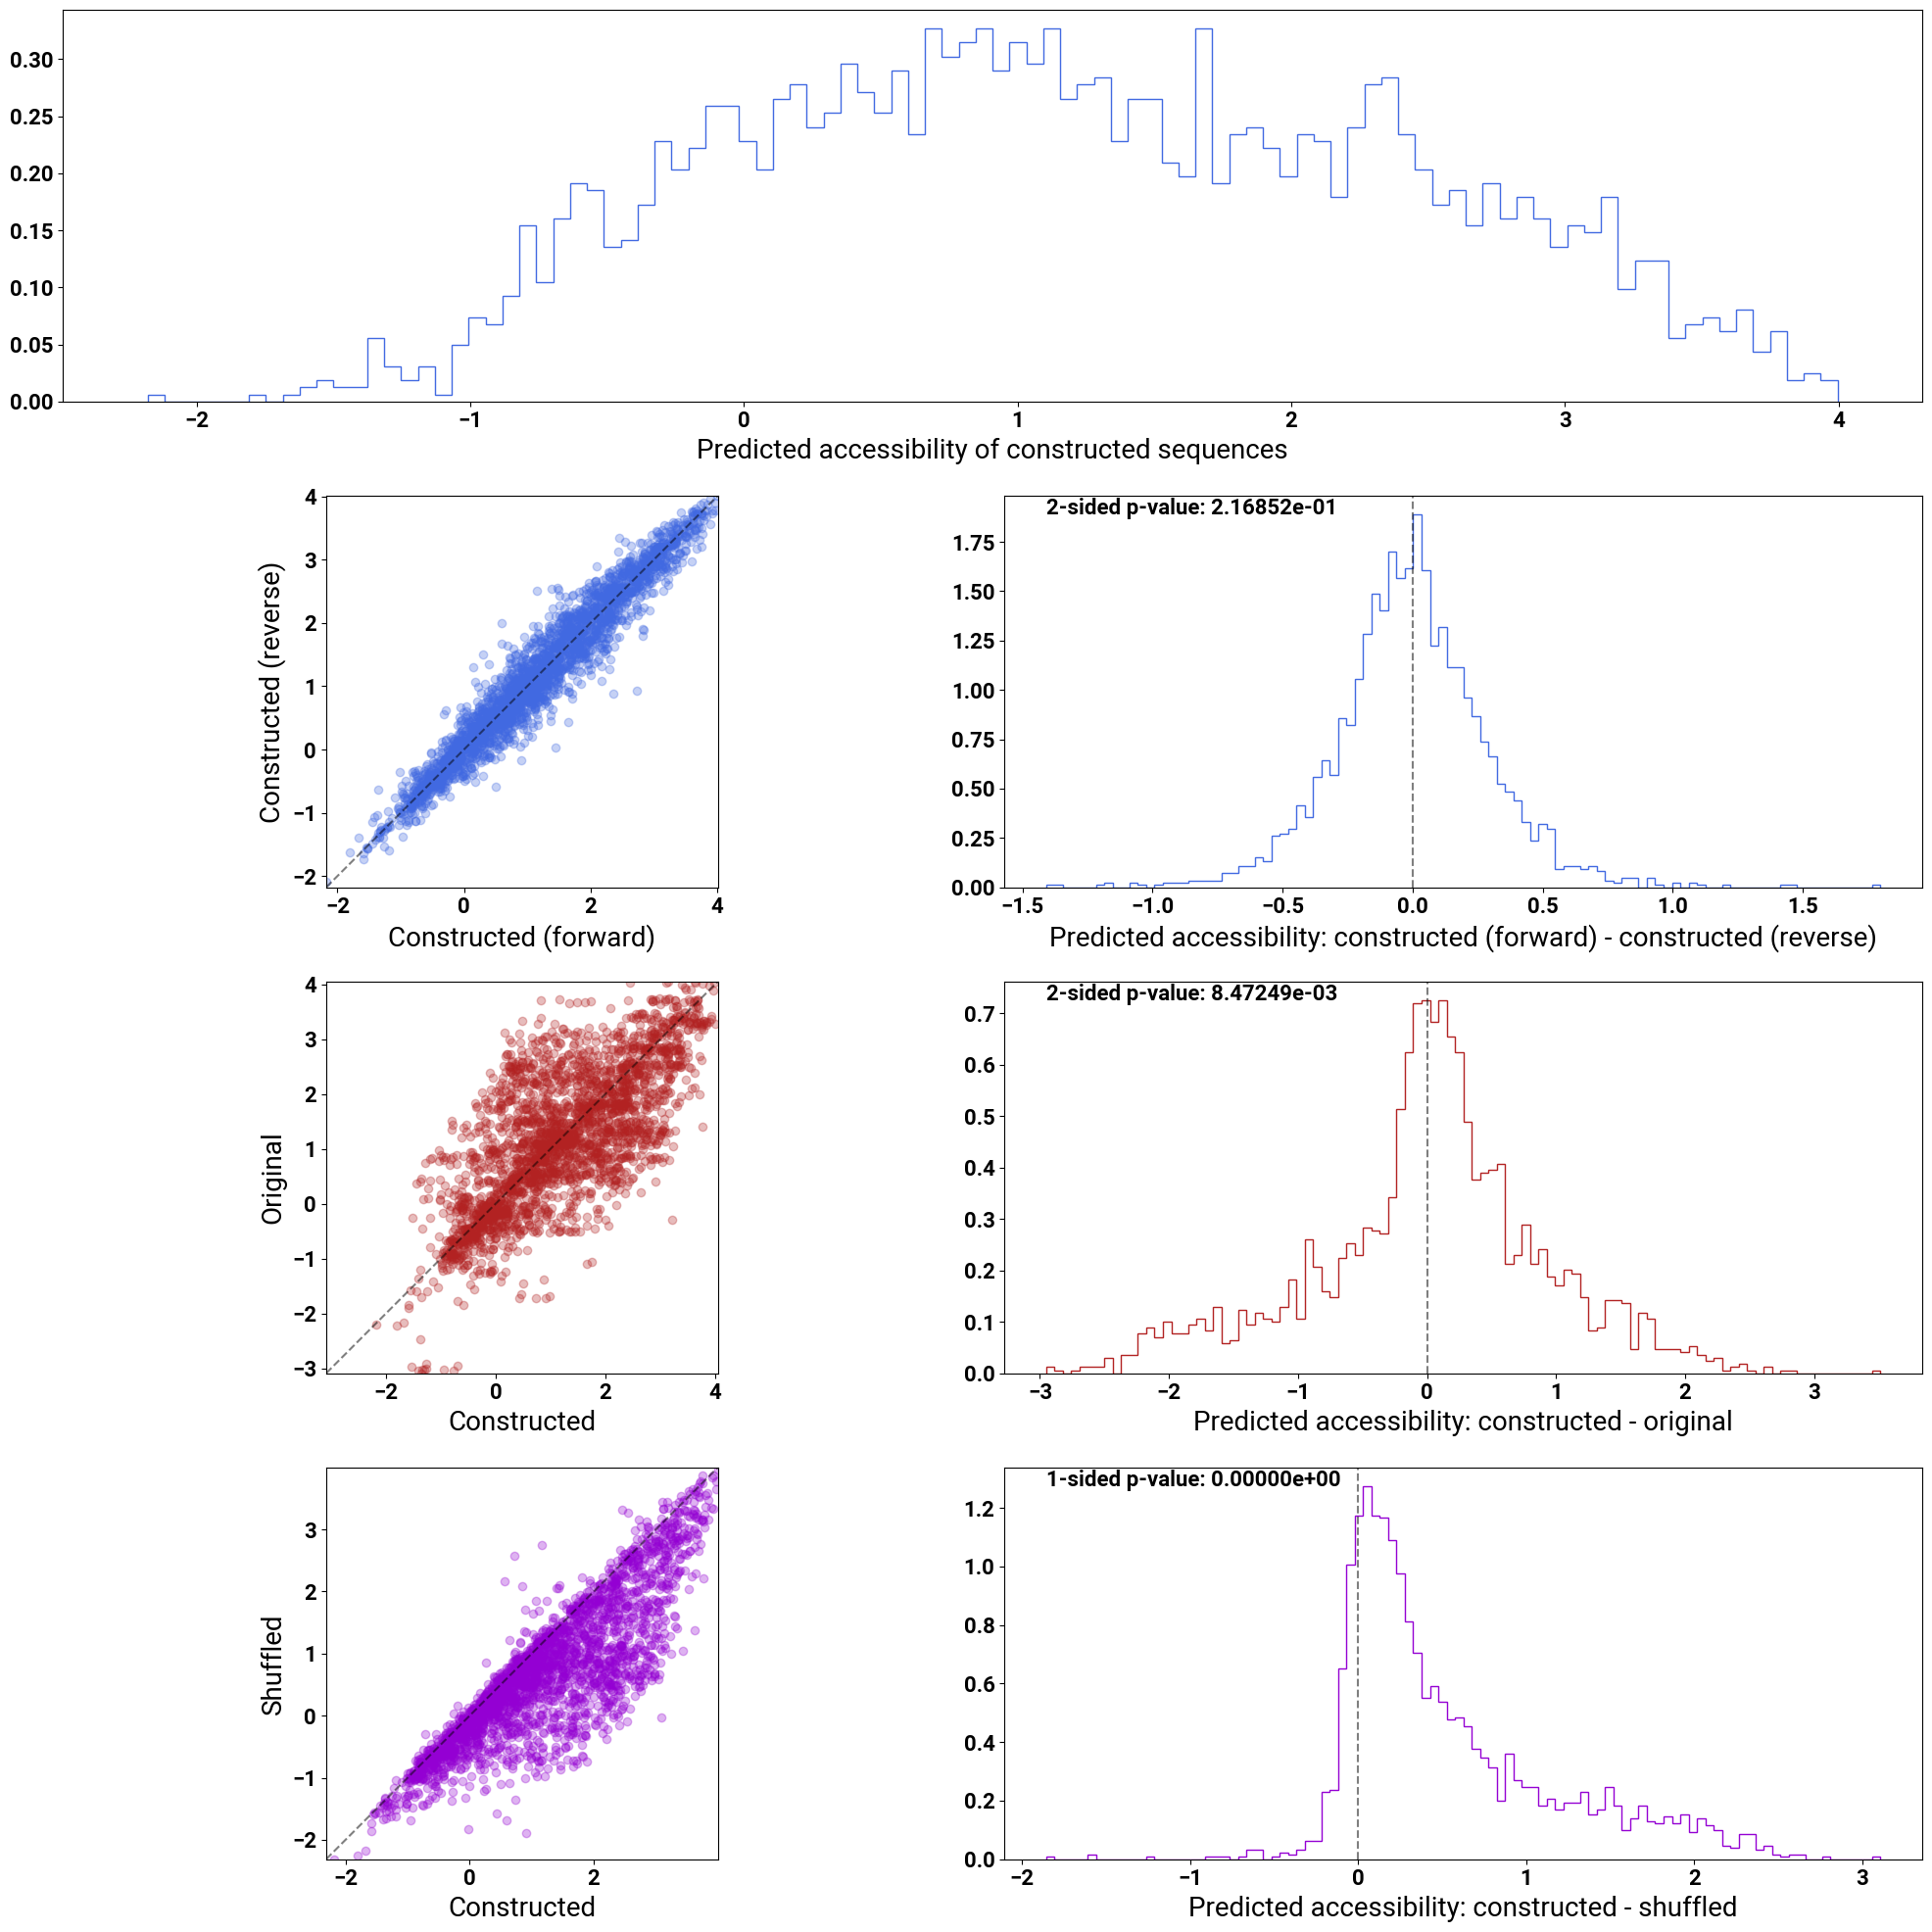

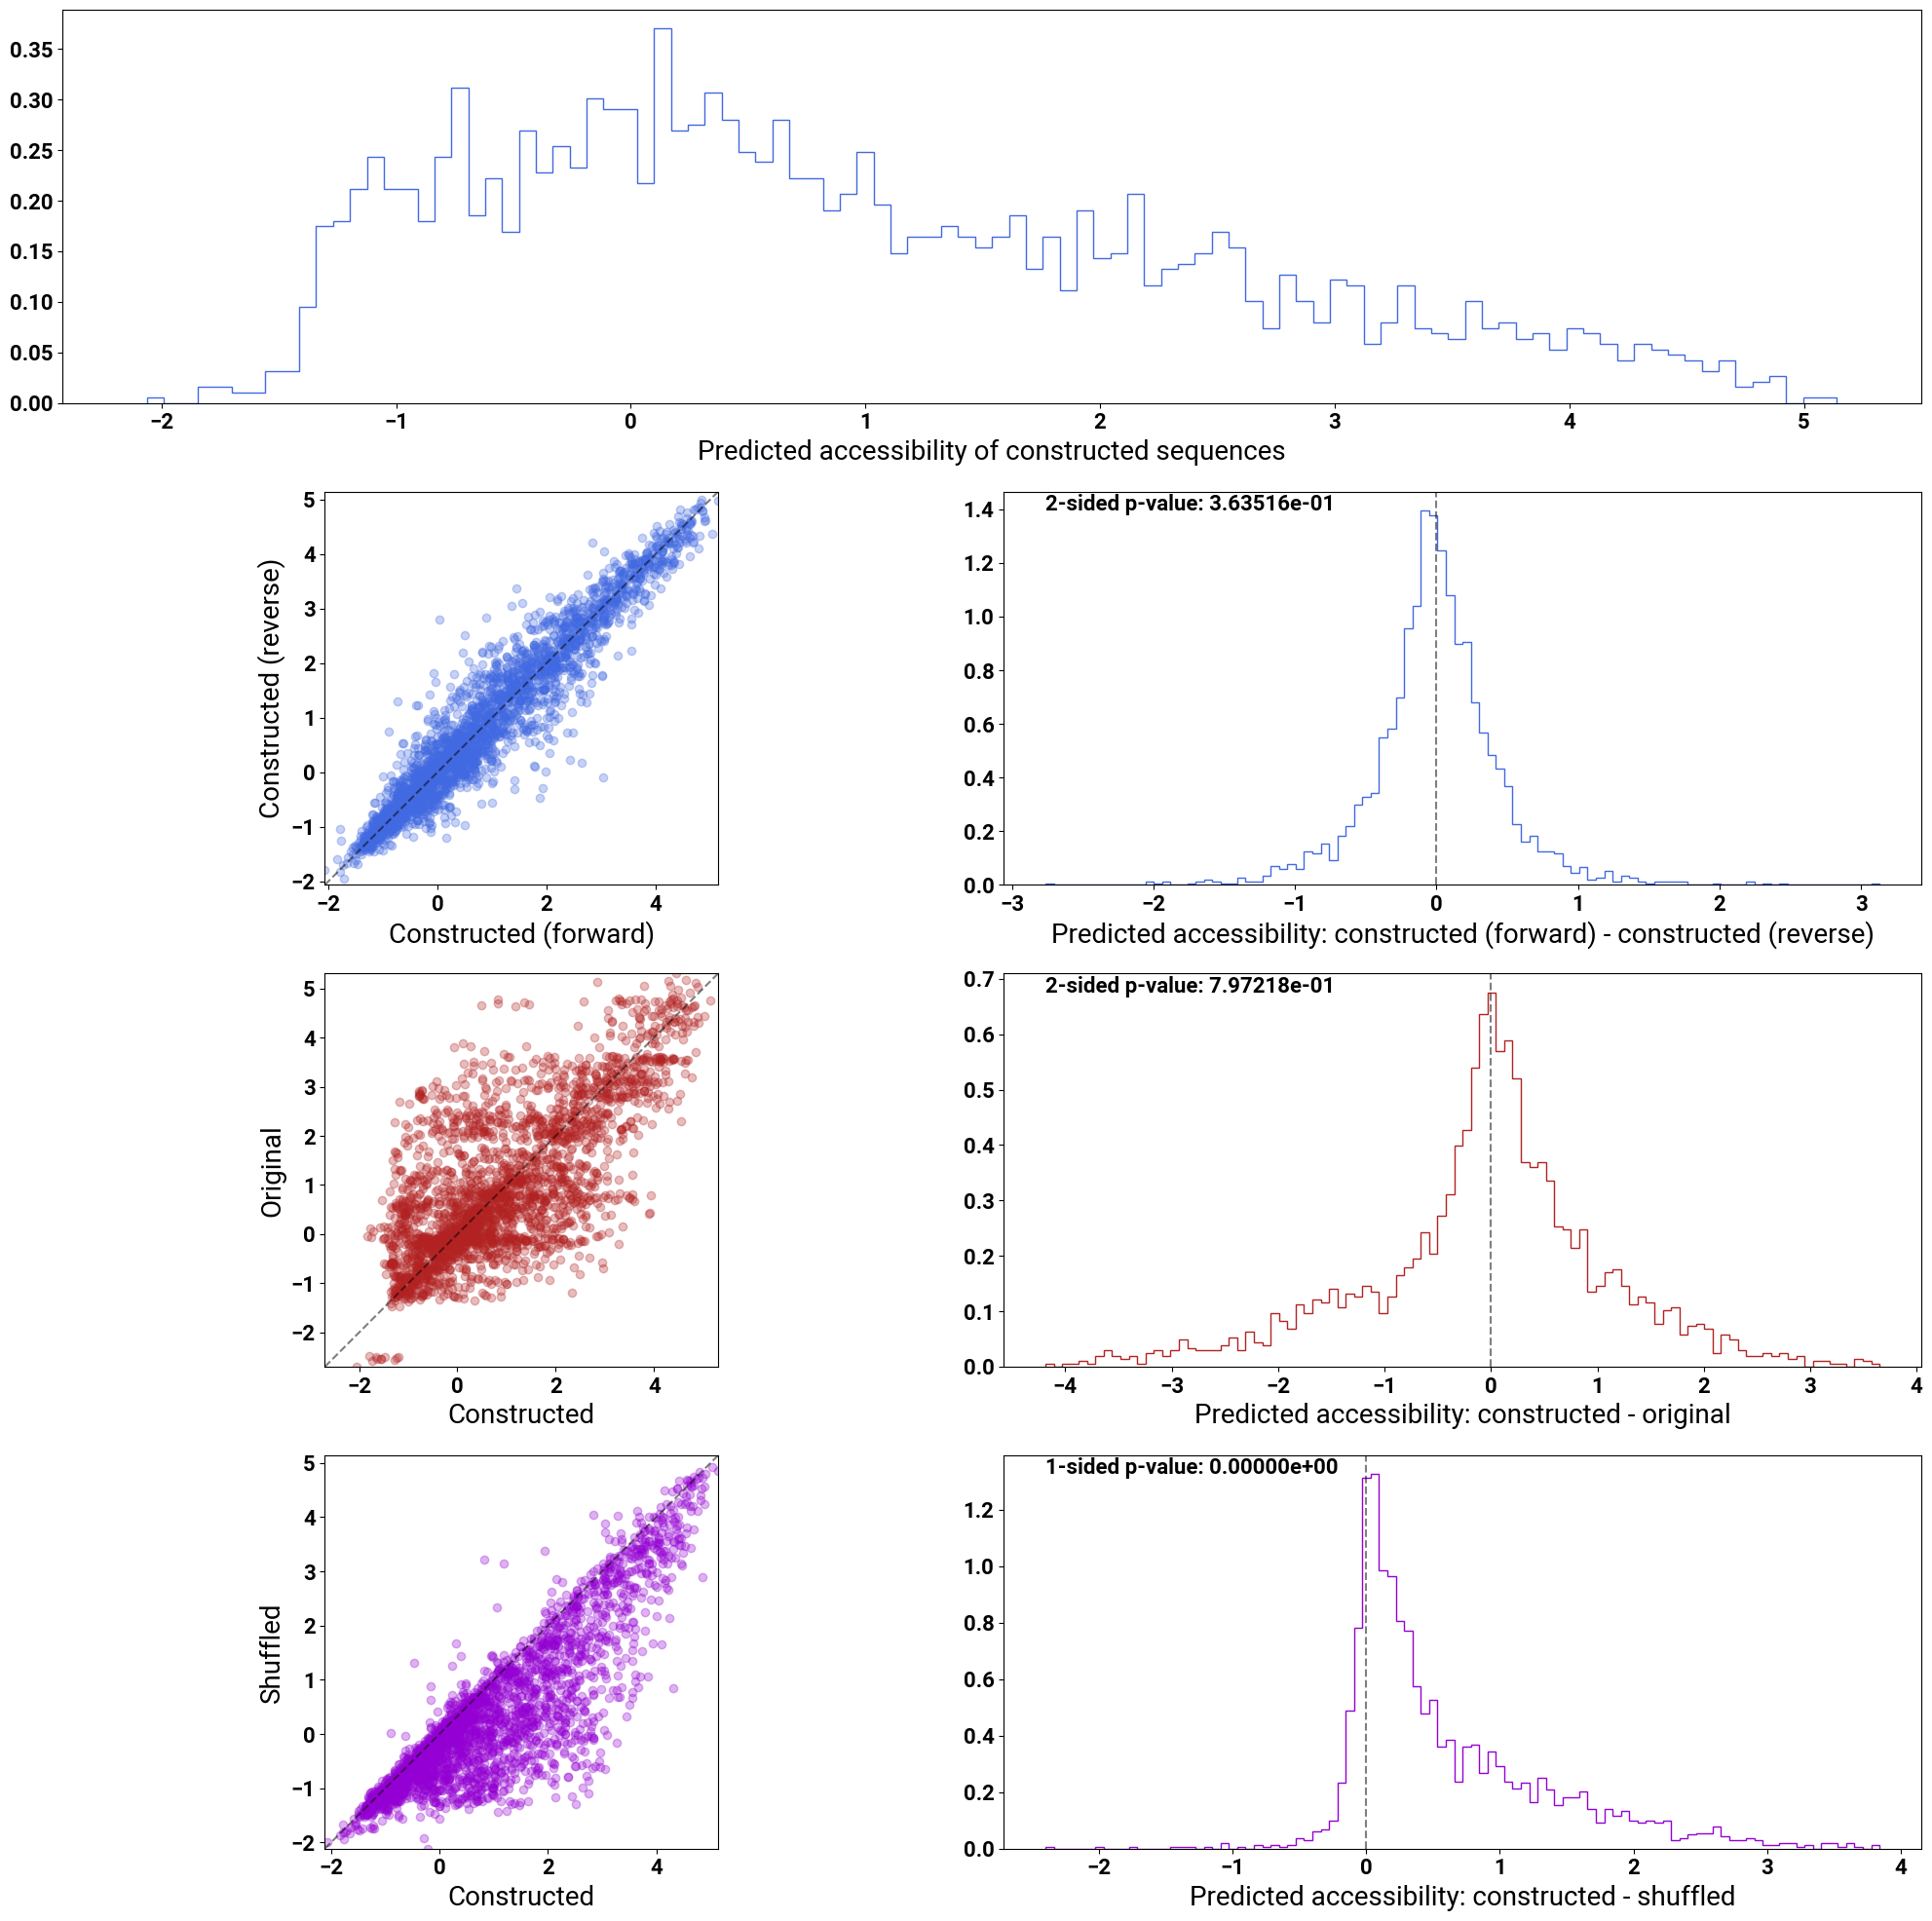

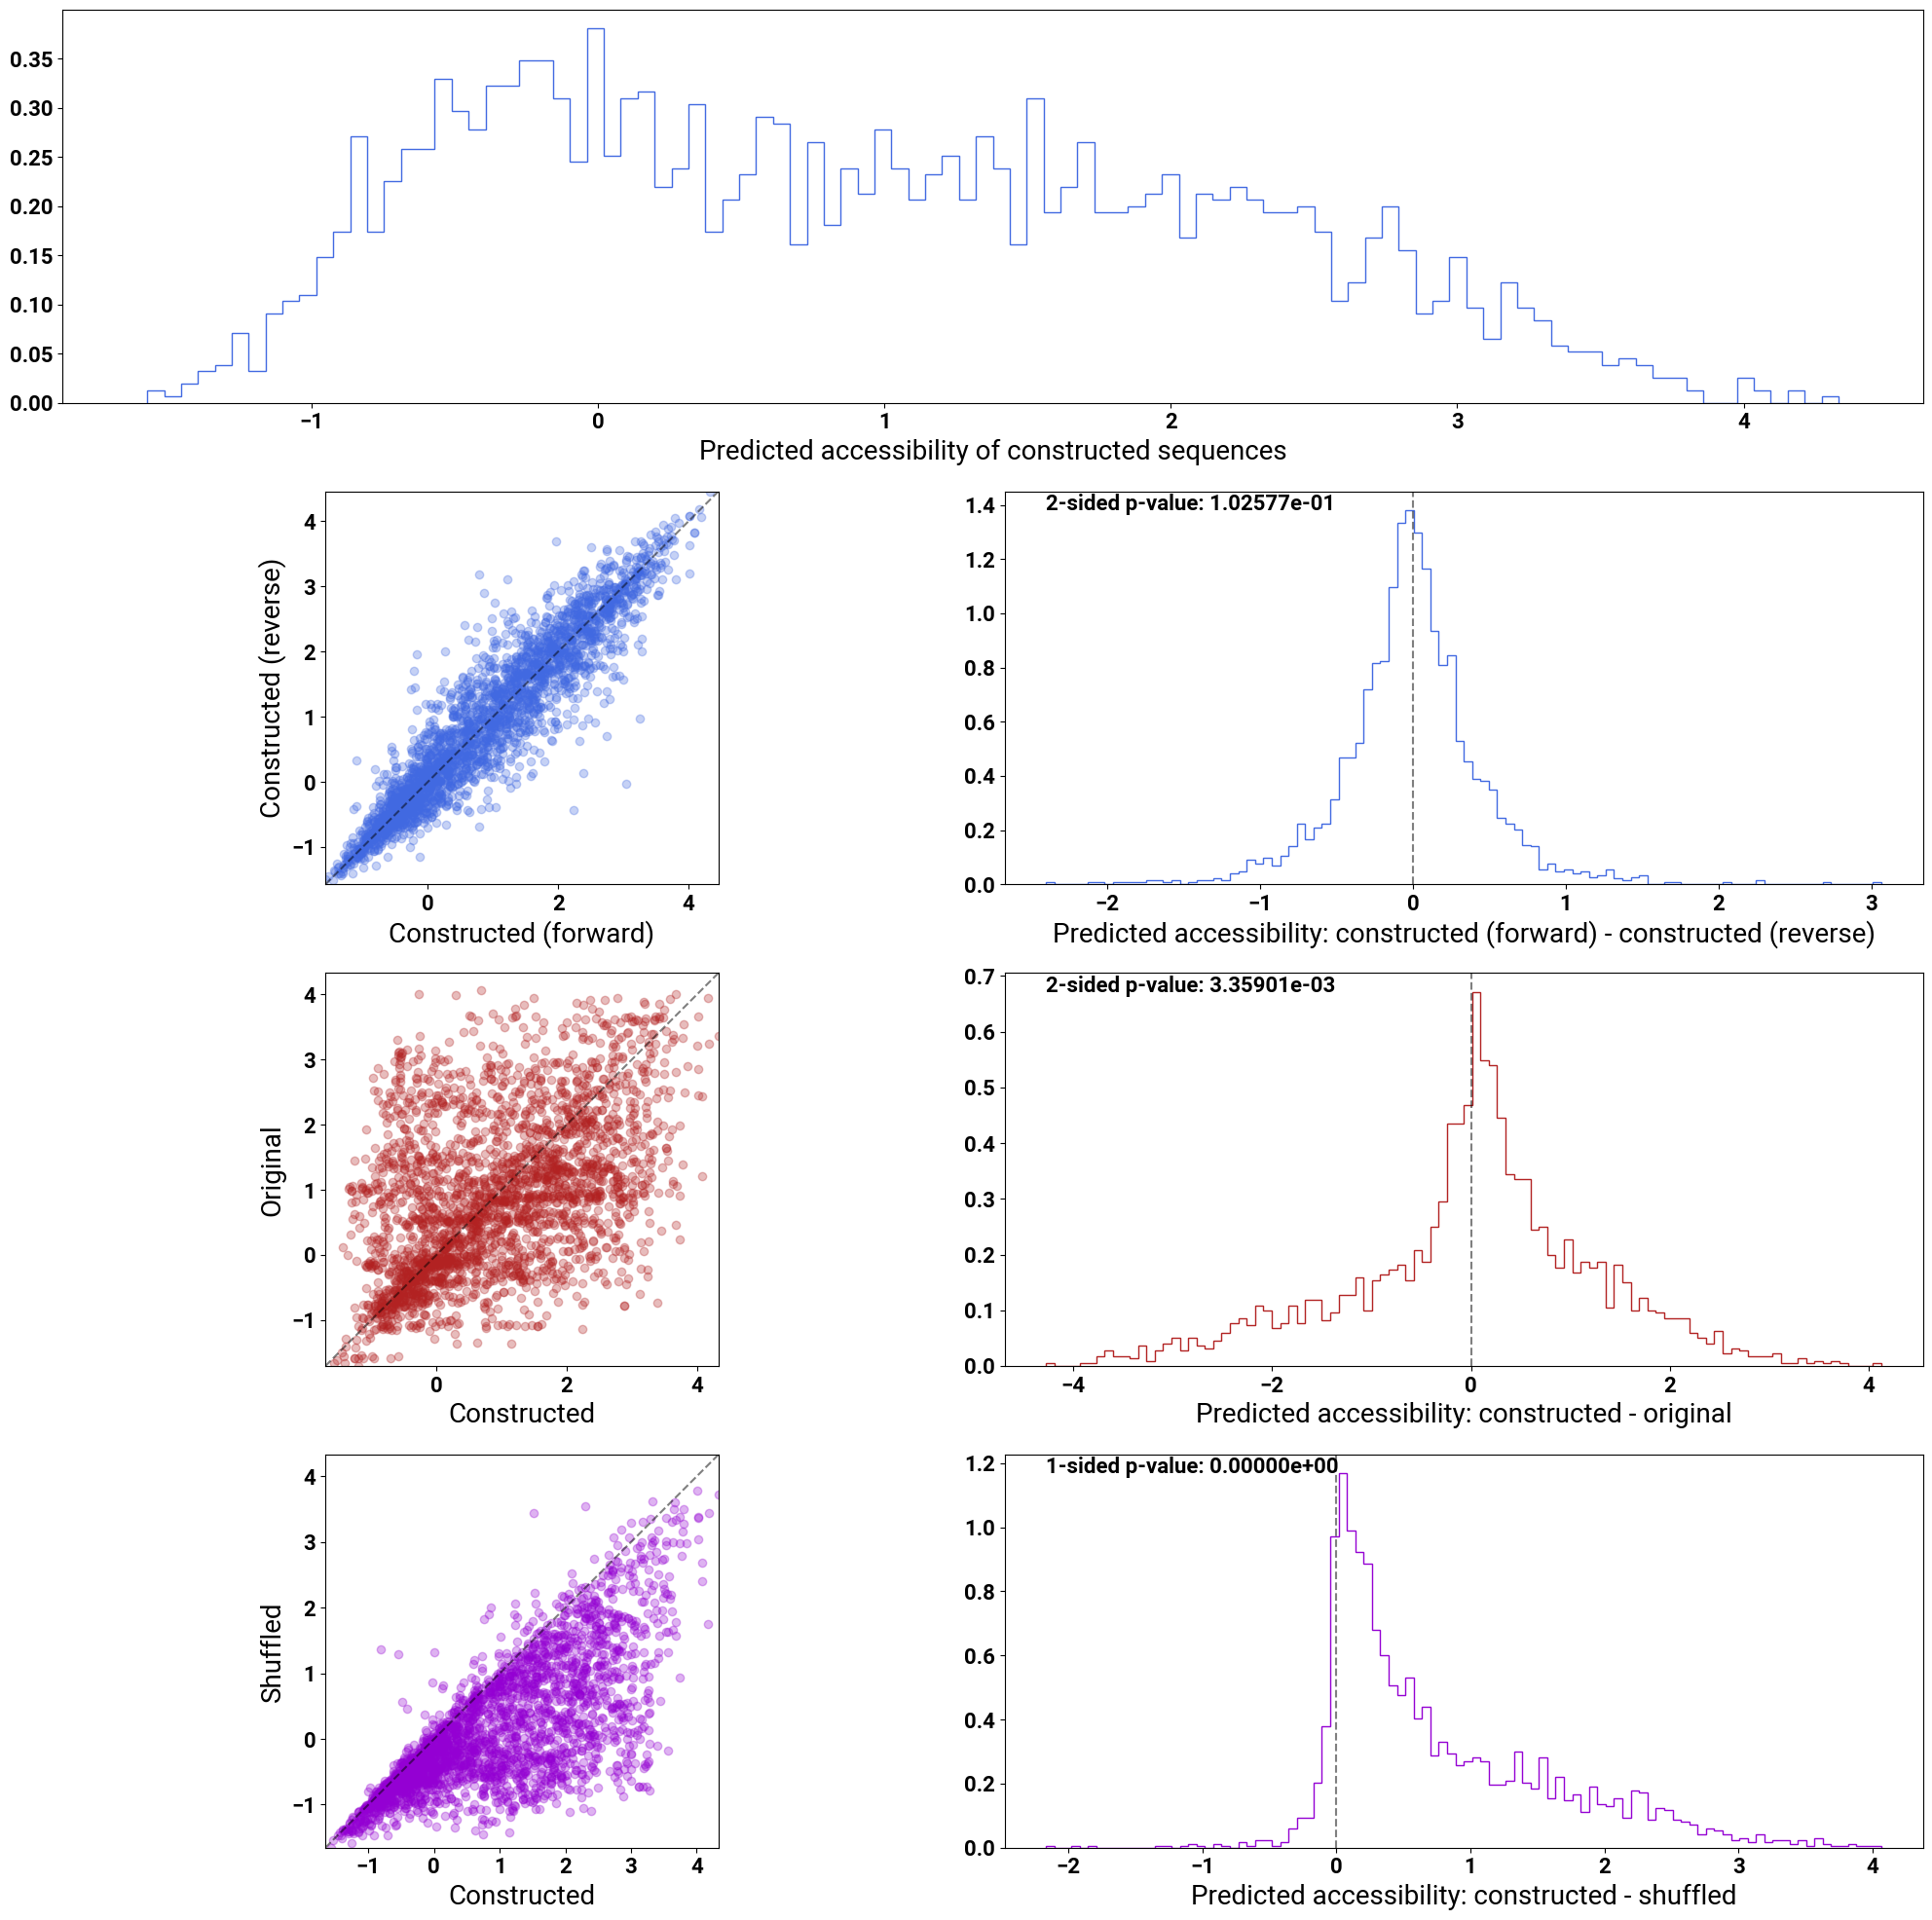

In [32]:
# Plot distribution of predictions
# Sum central window of profile predictions corresponding to ARGMINN input, and take log
borzoi_output_len = cons_borzoi_preds.shape[2]
num_bins = int(np.ceil(mechint_input_len / borzoi_model.data_params["train_bin_size"]))
bin_start = (borzoi_output_len // 2) - (num_bins // 2)
bin_end = bin_start + num_bins

cons_borzoi_preds_sum = np.log(np.sum(cons_borzoi_preds[:, :, bin_start : bin_end], axis=2))
cons_borzoi_rc_preds_sum = np.log(np.sum(cons_borzoi_rc_preds[:, :, bin_start : bin_end], axis=2))
orig_borzoi_preds_sum = np.log(np.sum(orig_borzoi_preds[:, :, bin_start : bin_end], axis=2))
shuf_borzoi_preds_sum = np.log(np.sum(shuf_borzoi_preds[:, :, bin_start : bin_end], axis=2))

for task_i in range(cons_borzoi_preds_sum.shape[1]):
    plot_pred_distributions(
        cons_borzoi_preds_sum[:, task_i], cons_borzoi_rc_preds_sum[:, task_i],
        orig_borzoi_preds_sum[:, task_i], shuf_borzoi_preds_sum[:, task_i]
    )

### Test new sequences on open-chromatin model

In [33]:
# Import open-chromatin models
def import_oc_model(model_name):
    artifact = grelu.resources.get_artifact(
        model_name,
        "human-atac-encode-cell_lines"
    )
    
    # Due to versioning issues, we need to update the checkpoint first
    artifact_dir = artifact.download()
    ckpt_file = os.path.join(artifact_dir, "model.ckpt")
    new_ckpt_file = os.path.join(artifact_dir, "new_model.ckpt")
    grelu.io.update_ckpt(ckpt_file, new_ckpt_file)
    
    return grelu.lightning.LightningModel.load_from_checkpoint(new_ckpt_file).to(DEVICE)

oc_binary_model = import_oc_model("model_binary_200bp")
oc_zscore_model = import_oc_model("model_log_zcore_200bp")

wandb: Downloading large artifact model_binary_200bp:latest, 272.77MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.4


Saving new checkpoint to /home/tsenga5/mechint_regnet/notebooks/artifacts/model_binary_200bp:v4/new_model.ckpt


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.4
wandb: Downloading large artifact model_log_zcore_200bp:latest, 272.77MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0


Saving new checkpoint to /home/tsenga5/mechint_regnet/notebooks/artifacts/model_log_zcore_200bp:v5/new_model.ckpt


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


In [34]:
# Define relevant output task
print(oc_binary_model.data_params["tasks"]["name"])
print(oc_zscore_model.data_params["tasks"]["name"])
task_index = 1

['GM12878', 'HepG2', 'IMR90', 'Jurkat', 'K562', 'SKNSH', 'WTC11']
['GM12878', 'HepG2', 'IMR90', 'Jurkat', 'K562', 'SKNSH', 'WTC11']


In [35]:
def get_oc_predictions(model, one_hots, task_index):
    """
    Given a trained model and B x L x 4 NumPy array of one-hot sequences,
    runs predictions and returns the B-array of predicted probabilities.
    """
    model.eval()
    return model.forward(
        torch.tensor(np.swapaxes(one_hots, 1, 2)).to(DEVICE).float()
    ).squeeze(2).detach().cpu().numpy()[:, task_index]

In [36]:
# Compute predictions
cons_ocb_preds = get_oc_predictions(oc_binary_model, cons_one_hots, task_index)
cons_ocb_rc_preds = get_oc_predictions(oc_binary_model, np.flip(cons_one_hots, axis=(1, 2)).copy(), task_index)
orig_ocb_preds = get_oc_predictions(oc_binary_model, orig_one_hots, task_index)
shuf_ocb_preds = get_oc_predictions(oc_binary_model, shuf_one_hots, task_index)

cons_ocz_preds = get_oc_predictions(oc_zscore_model, cons_one_hots, task_index)
cons_ocz_rc_preds = get_oc_predictions(oc_zscore_model, np.flip(cons_one_hots, axis=(1, 2)).copy(), task_index)
orig_ocz_preds = get_oc_predictions(oc_zscore_model, orig_one_hots, task_index)
shuf_ocz_preds = get_oc_predictions(oc_zscore_model, shuf_one_hots, task_index)

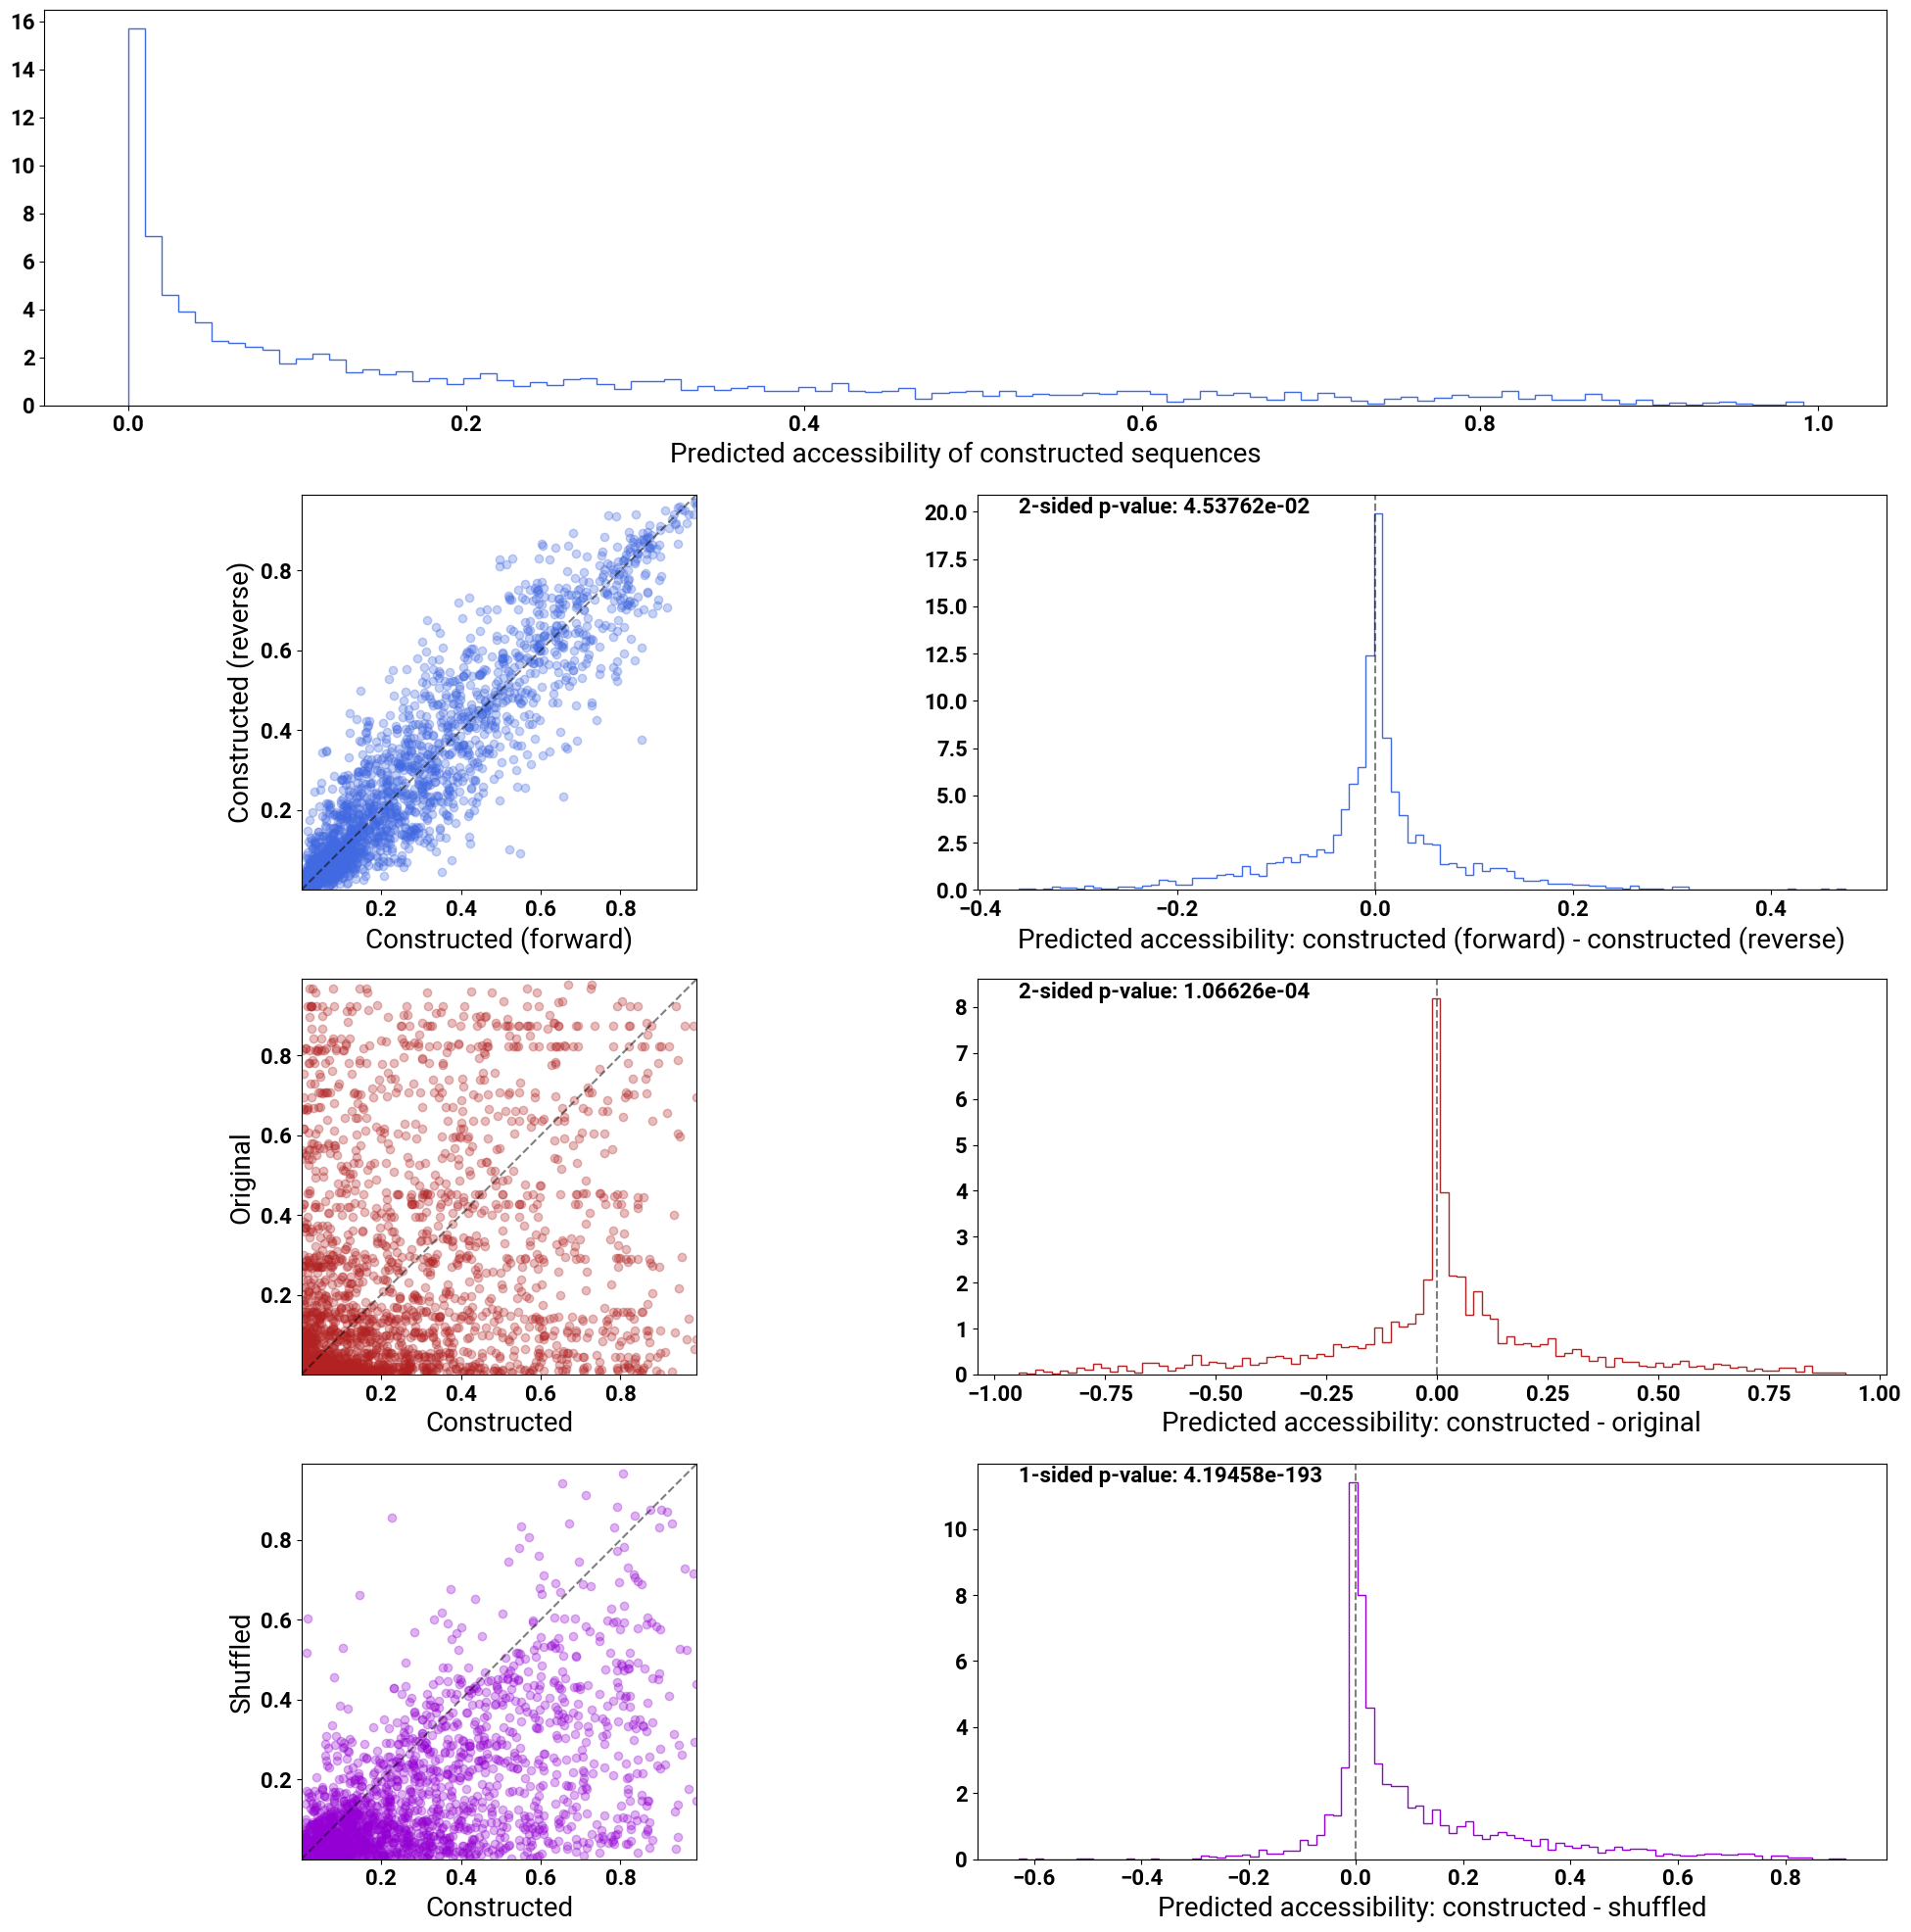

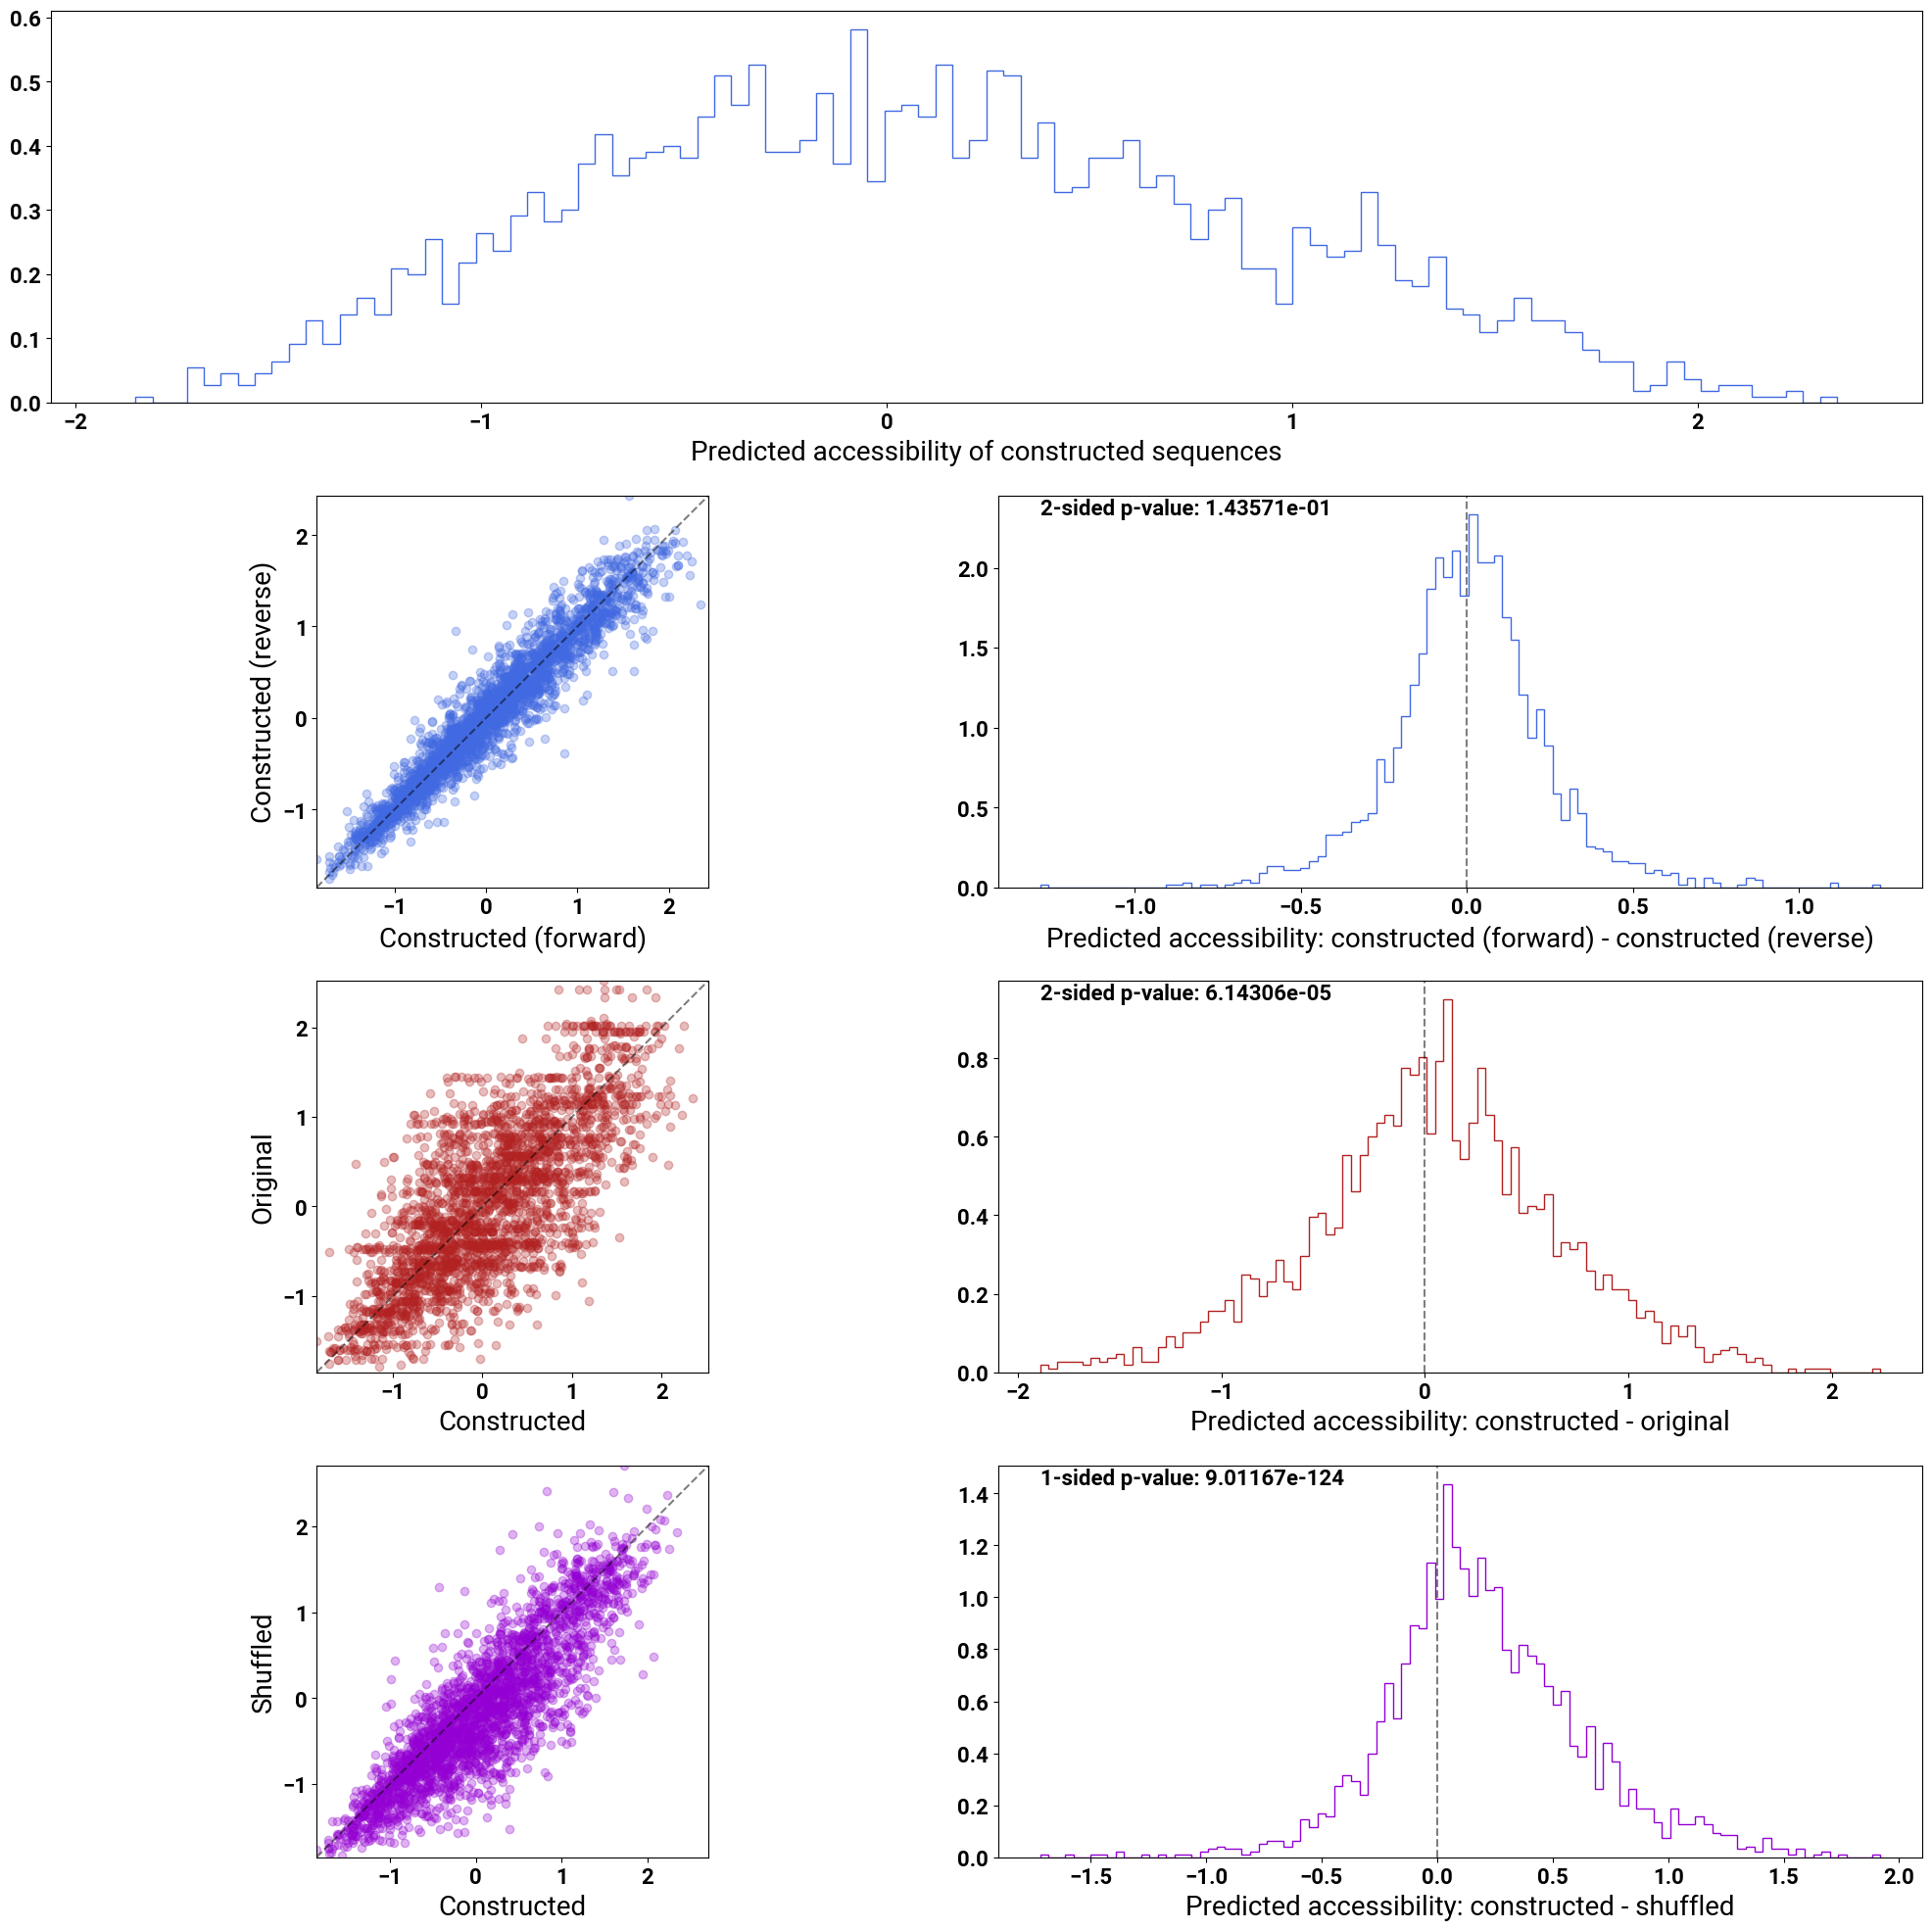

In [37]:
# Plot distribution of predictions
plot_pred_distributions(cons_ocb_preds, cons_ocb_rc_preds, orig_ocb_preds, shuf_ocb_preds)
plot_pred_distributions(cons_ocz_preds, cons_ocz_rc_preds, orig_ocz_preds, shuf_ocz_preds)

### Test new sequences on MPRA model

In [38]:
# Import MPRA model
artifact = grelu.resources.get_artifact(
    "model",
    "human-mpra-gosai-2023"
)

artifact_dir = artifact.download()
ckpt_file = os.path.join(artifact_dir, "model.ckpt")
new_ckpt_file = os.path.join(artifact_dir, "new_model.ckpt")
# Need to change GPU location
mpra_model = grelu.lightning.LightningModel.load_from_checkpoint(ckpt_file, map_location={"cuda:1": "cuda:0"}).to(DEVICE)

wandb: Downloading large artifact model:latest, 999.24MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.1
/home/tsenga5/miniforge3/envs/grelu/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.3.0, which is newer than your current Lightning version: v2.2.2
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


In [39]:
# Define relevant output task
print(mpra_model.data_params["tasks"]["name"])
task_index = 0

['hepg2', 'k562', 'sknsh']


In [40]:
def get_mpra_predictions(model, one_hots, task_index):
    """
    Given a trained model and B x L x 4 NumPy array of one-hot sequences,
    runs predictions and returns the B-array of predicted probabilities.
    """
    model.eval()
    return model.forward(
        torch.tensor(np.swapaxes(one_hots, 1, 2)).to(DEVICE).float()
    ).squeeze(2).detach().cpu().numpy()[:, task_index]

In [41]:
# Compute predictions
cons_mpra_preds = get_mpra_predictions(mpra_model, cons_one_hots, task_index)
cons_mpra_rc_preds = get_mpra_predictions(mpra_model, np.flip(cons_one_hots, axis=(1, 2)).copy(), task_index)
orig_mpra_preds = get_mpra_predictions(mpra_model, orig_one_hots, task_index)
shuf_mpra_preds = get_mpra_predictions(mpra_model, shuf_one_hots, task_index)

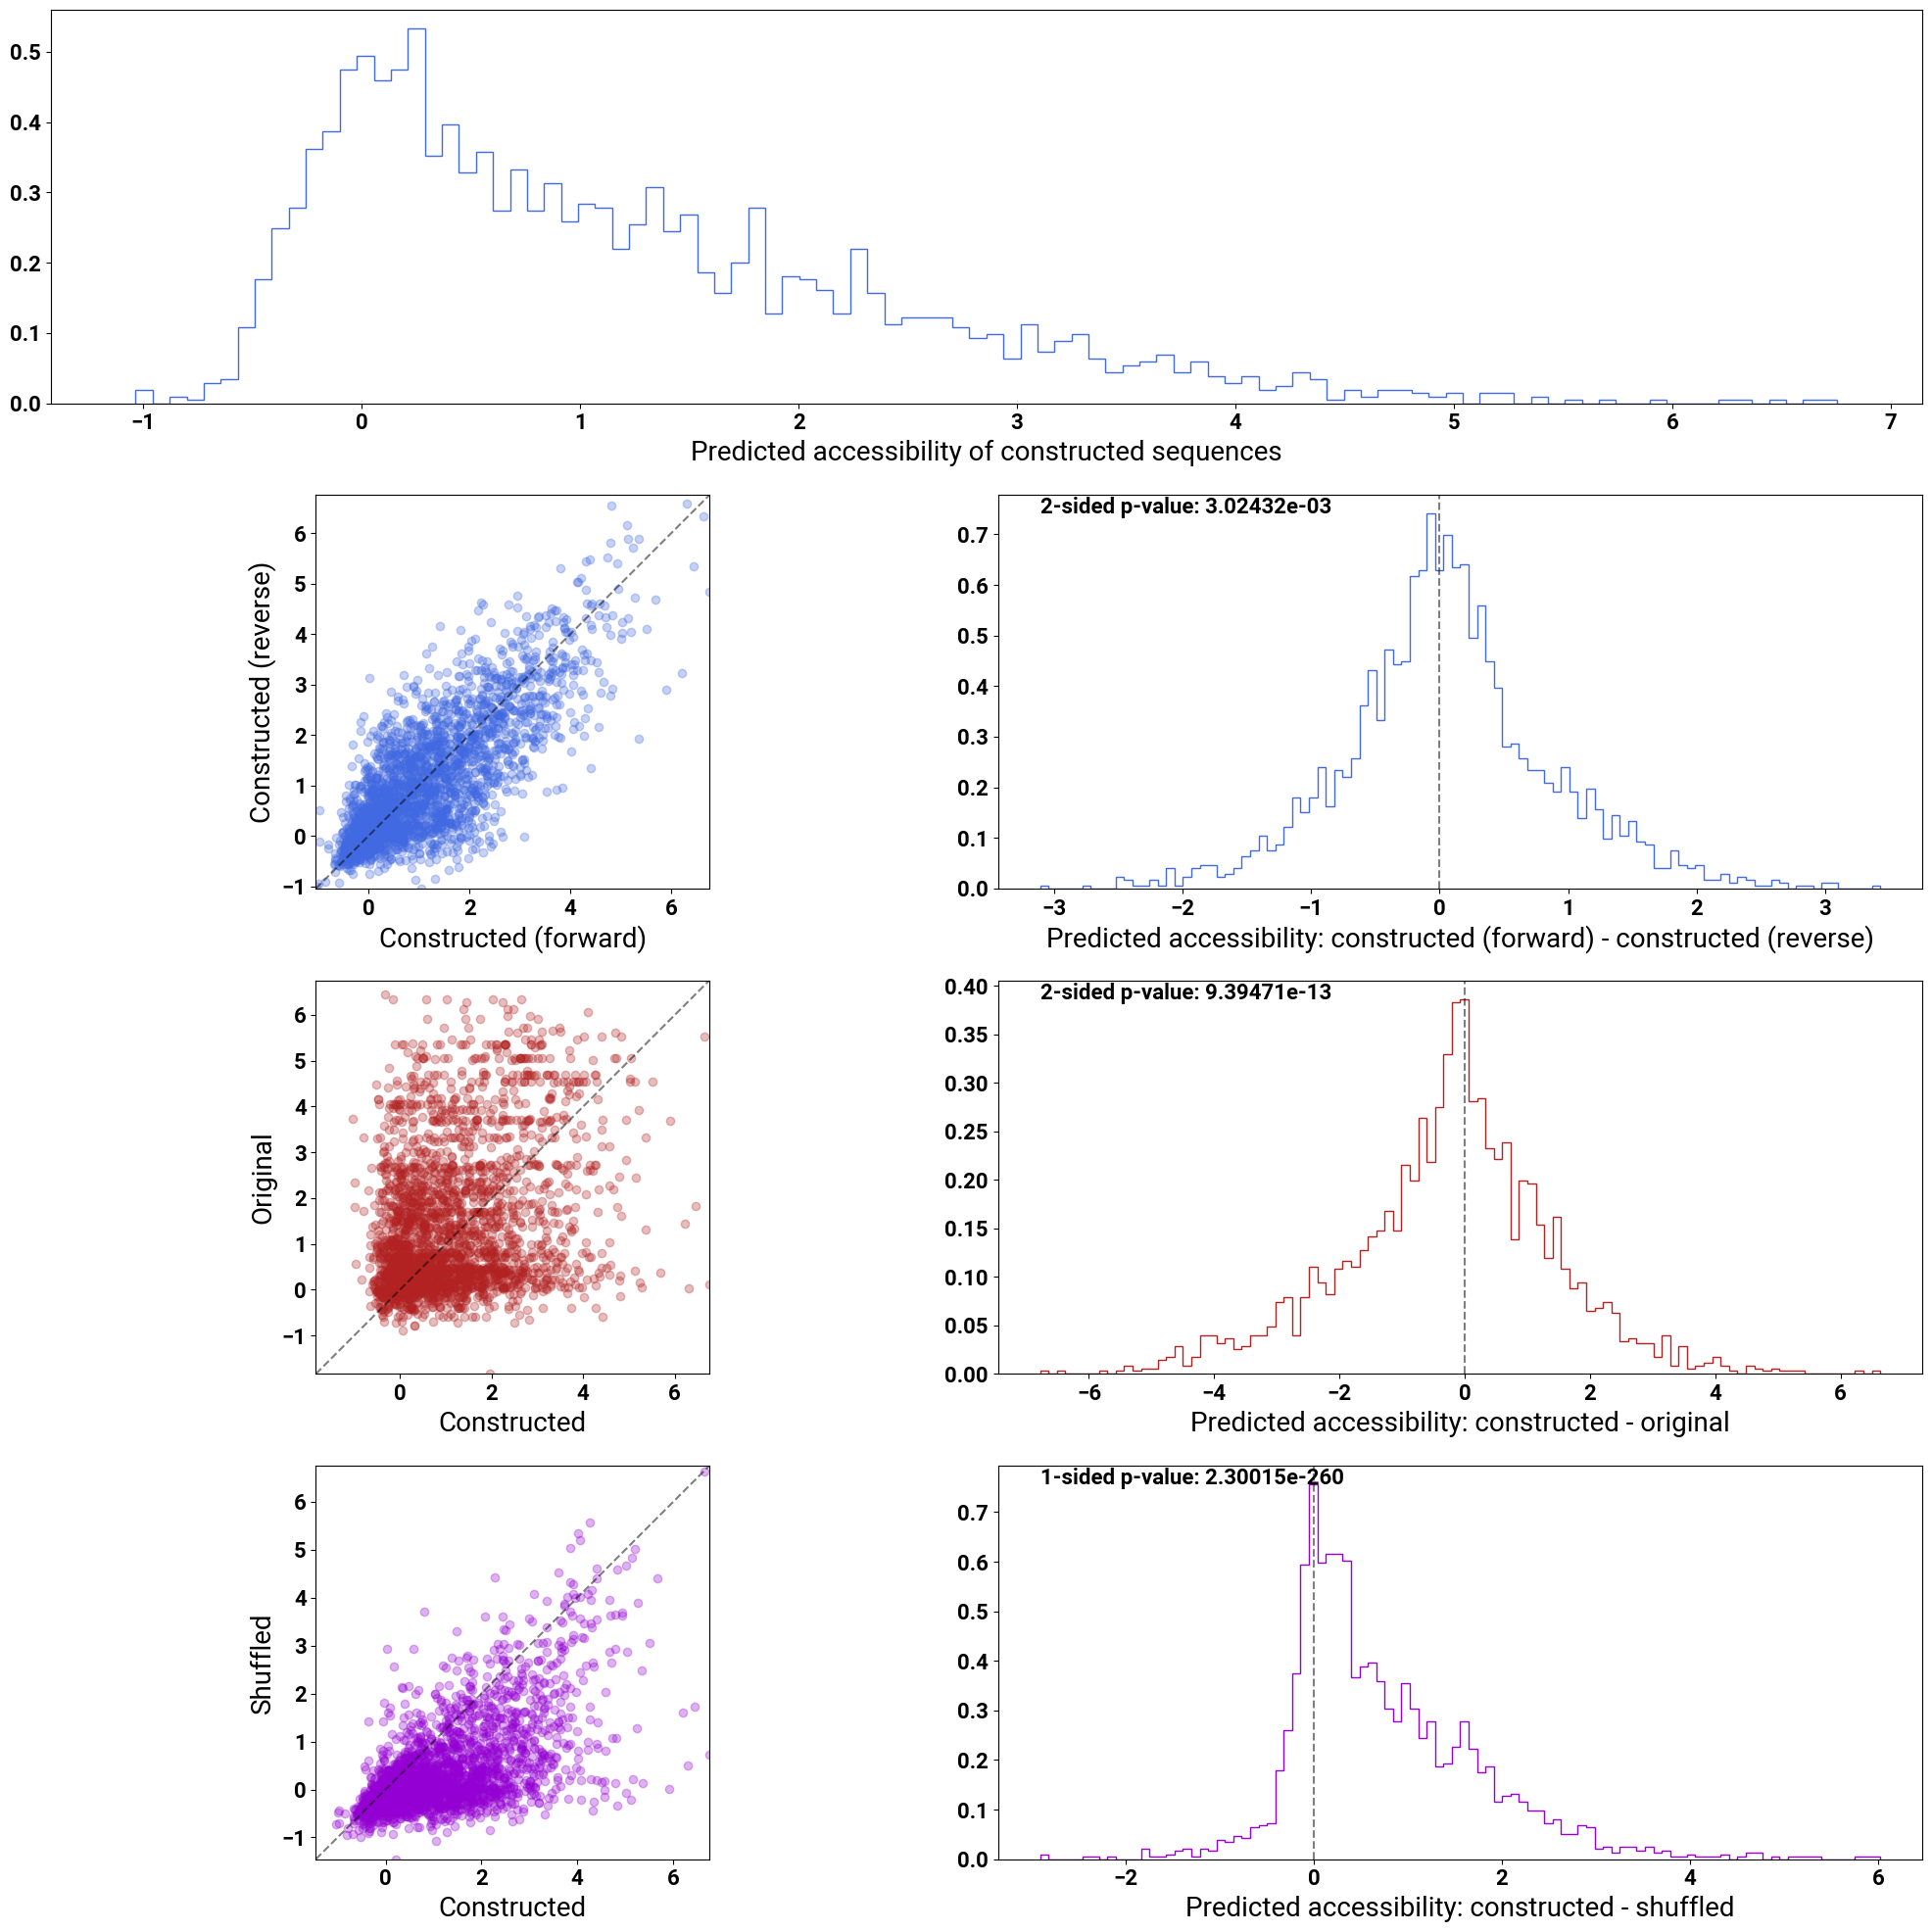

In [42]:
# Plot distribution of predictions
plot_pred_distributions(cons_mpra_preds, cons_mpra_rc_preds, orig_mpra_preds, shuf_mpra_preds)

### Save sequences and predictions

In [43]:
seq_table = pd.DataFrame({
    "cons_seq": pd.Series(feature_util.one_hot_to_seqs(cons_one_hots)),
    "orig_seq": pd.Series(feature_util.one_hot_to_seqs(orig_one_hots)),
    "shuf_seq": pd.Series(feature_util.one_hot_to_seqs(shuf_one_hots)),
})

seq_table["chrom"] = pd.Series([config[0][0] for config in cons_configs])
seq_table["start"] = pd.Series([config[0][1] for config in cons_configs])
seq_table["end"] = pd.Series([config[0][2] for config in cons_configs])

seq_table["motif_key"] = pd.Series(["|".join([pair[1] for pair in config[1]]) for config in cons_configs])
seq_table["motif_pos"] = pd.Series(["|".join([str(pair[0]) for pair in config[1]]) for config in cons_configs])

seq_table["cons_mechint_preds"] = pd.Series(cons_mechint_preds)
seq_table["cons_mechint_rc_preds"] = pd.Series(cons_mechint_rc_preds)
seq_table["orig_mechint_preds"] = pd.Series(orig_mechint_preds)
seq_table["shuf_mechint_preds"] = pd.Series(shuf_mechint_preds)

seq_table["cons_borzoi_preds"] = pd.Series(cons_borzoi_preds_sum[:, -1])
seq_table["cons_borzoi_rc_preds"] = pd.Series(cons_borzoi_rc_preds_sum[:, -1])
seq_table["orig_borzoi_preds"] = pd.Series(orig_borzoi_preds_sum[:, -1])
seq_table["shuf_borzoi_preds"] = pd.Series(shuf_borzoi_preds_sum[:, -1])

seq_table["cons_ocb_preds"] = pd.Series(cons_ocb_preds)
seq_table["cons_ocb_rc_preds"] = pd.Series(cons_ocb_rc_preds)
seq_table["orig_ocb_preds"] = pd.Series(orig_ocb_preds)
seq_table["shuf_ocb_preds"] = pd.Series(shuf_ocb_preds)

seq_table["cons_ocz_preds"] = pd.Series(cons_ocz_preds)
seq_table["cons_ocz_rc_preds"] = pd.Series(cons_ocz_rc_preds)
seq_table["orig_ocz_preds"] = pd.Series(orig_ocz_preds)
seq_table["shuf_ocz_preds"] = pd.Series(shuf_ocz_preds)

seq_table["cons_mpra_preds"] = pd.Series(cons_mpra_preds)
seq_table["cons_mpra_rc_preds"] = pd.Series(cons_mpra_rc_preds)
seq_table["orig_mpra_preds"] = pd.Series(orig_mpra_preds)
seq_table["shuf_mpra_preds"] = pd.Series(shuf_mpra_preds)

In [44]:
seq_table.to_csv(
    os.path.join(out_path, "seq_table.tsv"),
    sep="\t", index=False
)